In [1]:
import sys

sys.path.append('../../../common_code')
from PostProcessingScripts import * 
from formation_channels import * 
import astropy.stats

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

##########
# define colors for formation channels 
channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}

channelColorDict_lighter = {'classic':adjust_lightness(color='#118AB2', amount=1.6),'stable B no CEE':adjust_lightness(color='orange', amount=1.4), 'immediate CE':adjust_lightness(color='#EF476F', amount=1.2),\
                            r'double-core CE':adjust_lightness(color='#073B4C', amount=1.8), 'other':adjust_lightness(color='gray', amount=1.5),  'vi':adjust_lightness(color='cyan', amount=1.5), 'vii':adjust_lightness(color='#FFD166', amount=1.2)}
channelList = ['classic', 'stable B no CEE', 'vii',  'immediate CE',  r'double-core CE', 'other'] #, 'vi']
#######


In [2]:
def obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/'):
    BPSmodelName='B'
    DCOtype='BNS'
    path_ = '/Volumes/SimonsFoundation/DataDCO/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    fdata = h5.File(path, 'r')
    redshifts = fdata['redshifts']['redshift'][...].squeeze()
    fdata.close()
    return redshifts 





adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run 
print('available redshifts:', redshifts_runs) 


available redshifts: [0.19230769 0.57692308 0.96153846 1.34615385 1.73076923 2.11538462
 2.5        2.88461538 3.26923077 3.65384615 4.03846154 4.42307692
 4.80769231 5.19230769 5.57692308 5.96153846 6.34615385 6.73076923
 7.11538462 7.5        7.88461538 8.26923077 8.65384615 9.03846154
 9.42307692 9.80769231]


In [3]:
def plot_total_quantiles_redshift(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', xparam='mass_tot', redshifts=[0],\
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                  c_FC=False, mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                               weights_type='formation'):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    
    
    for ind_m, BPSmodelName in  enumerate(BPSnameslist[0:]):
        print(BPSmodelName)
        color_m = colorDirDict[BPSmodelName]
    
        # path for files 
        full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(full_data_path,'r')

        # get the delay time in Gyr 


        massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
        massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
        # M1 will be the most massive, M2 the least massive compact object. 
        massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1

        if xparam=='chirp_mass_LVK':
            param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
            nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
            nameY = r'\textbf{PDF}'
            xx = np.linspace(1,100,1000)
        elif xparam=='mass_tot':
            param_x = massCO_LVKM1 + massCO_LVKM2
            nameX = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
            nameY = r'\textbf{PDF}'
            xx = np.linspace(1,5,1000)
        elif xparam=='mass_ratio_LVK':
            param_x = MassRatioCO_LVK
            nameX = r'$q$'
            nameY = r'\textbf{PDF}'
            xx = np.linspace(-0.2,1.2,1000)
        elif xparam=='mass_1_LVK':
            param_x = massCO_LVKM1
            nameX = r'$m_1 [M_{\odot}]$'
            nameY = r'\textbf{PDF}'
            if DCOtype=='BBH':
                xx = np.linspace(-1,150,1000) # needs to be a little bit larger
            elif DCOtype=='BHNS':
                xx = np.linspace(-1,50,1000)
            elif DCOtype=='BNS':
                xx = np.linspace(-2,5,500)
        elif xparam=='mass_2_LVK':
            param_x = massCO_LVKM2
            nameX = r'$m_2 [M_{\odot}]$'
            nameY = r'\textbf{PDF}'
            if DCOtype=='BBH':
                xx = np.linspace(-1,150,1000) # needs to be a little bit larger
            elif DCOtype=='BHNS':
                xx = np.linspace(-2,5,1000)
            elif DCOtype=='BNS':
                xx = np.linspace(-2,5,500)

        elif xparam=='log10_t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
            param_x = np.log10(param_x)
            nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
            nameY = r'\textbf{PDF}'  
            xx = np.linspace(-2.5,2,500)  
            print('obtained params')
        elif xparam=='log10_t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
            param_x = np.log10(param_x)
            nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
            nameY = r'\textbf{PDF}'  
            xx = np.linspace(-2.5,2,500)  
            print('obtained params')    

        elif xparam=='t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
            nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
            nameY = r'\textbf{PDF}'  
            xx = np.linspace(-2.5,2,500)     


        channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()


        print('obtained params')   

        for ind_mssfr, mssfr in enumerate(MSSFRnameslist[1:]):

            median_at_redshifts = np.zeros_like(redshifts_runs)

            for z_ind, redshift in enumerate(redshifts_runs[0:]):
                redshift = np.round(redshift,4)

                if weights_type=='merger':
                    fparam_key = 'weights_intrinsicPerRedshift'
                    weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                    weights_ = fdata[fparam_key][weightheader][...].squeeze()
                elif weights_type=='formation':
                    fparam_key = "weights_intrinsicFormationPerRedshift"
                    weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                    weights_ = fdata[fparam_key][weightheader][...].squeeze()



                if whichQuantity=='median':
                    median_at_redshifts[z_ind] = weighted_quantile(values=param_x, quantiles=[0.5], sample_weight=weights_)
                    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                elif whichQuantity=='fraction':
                    mask_systems = param_x <= value_for_fraction
                    median_at_redshifts[z_ind] = np.sum(weights_[mask_systems])/np.sum(weights_)
                    nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction


            axe.scatter(redshifts[:], median_at_redshifts, color=color_m, marker=dictMarkerShape[BPSmodelName])
            axe.plot(redshifts[:],    median_at_redshifts, color=color_m) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
        # always close the dataset
        fdata.close()


        
        
    xlabel = r'\textbf{redshift} $z$'
    ylabel = nameX
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
    axe.set_xlim(0,9.6)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
    
    #axe.set_ylim(2,3.8)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        if xparam in ['t_delay']:
            axe.set_yscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe





at DCOtype = BNS
A
obtained params
B
obtained params
C
obtained params
D
obtained params
E
obtained params


/Users/floorbroekgaarden/Projects/GitHub/DCO_FormationChannels/plottingCode/Figure_Redshift_Rates/../../../common_code/PostProcessingScripts.py:1152: RuntimeWarning: invalid value encountered in divide
  weighted_quantiles /= np.sum(sample_weight)


F
obtained params
G
obtained params
H
obtained params
I
obtained params
J
obtained params
K
obtained params
L
obtained params
M
obtained params
N
obtained params
O
obtained params
P
obtained params
Q
obtained params
R
obtained params
S
obtained params
T
obtained params


FileNotFoundError: [Errno 2] No such file or directory: './formation_median/t_delay/t_delay_total_ratesz_BNS_formation_median.png'

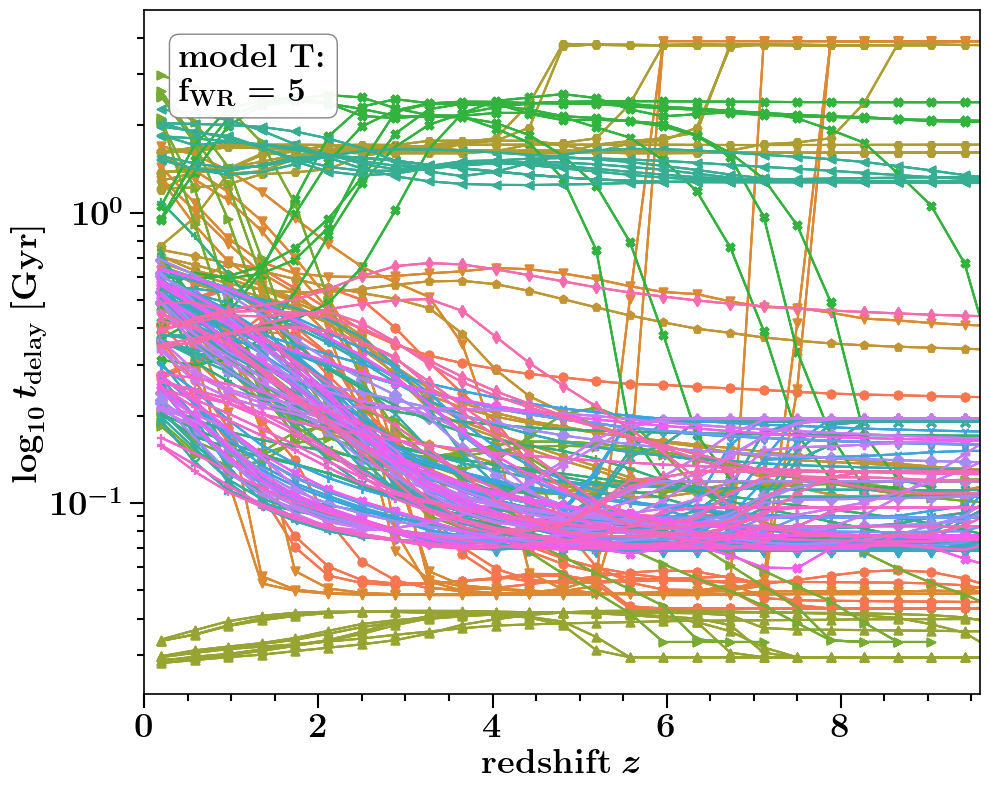

In [28]:
# plot delay times with fraction 

weights_type='formation'
whichQuantity='median'
xparam = 't_delay' #'mass_tot'


for DCOtype in [ 'BNS']:
    print()
    print('at DCOtype =', DCOtype)


    ncols, nrows= 1,1
    f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



    ax = plot_total_quantiles_redshift(axe=ax, DCOtype=DCOtype, xparam=xparam, BPSmodelName=BPSmodelName,\
                                                          redshifts=redshifts_runs, pathData=pathData,\
                                                        c_FC=color_m, mask_specific_mssfr='x',\
                                                     whichQuantity=whichQuantity, value_for_fraction=0.1,\
                                                    weights_type=weights_type) 


    ##  SAVE FIG  ###
    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.18)  
    plt.savefig('./formation_median/'+xparam+'/'+xparam+'_total_ratesz_' +  DCOtype + '_' + weights_type + '_' + whichQuantity + '.png', transparent=False)
    plt.savefig('./formation_median/'+xparam+'/'+xparam+'_total_ratesz_' +  DCOtype + '_' + weights_type + '_' + whichQuantity + '.pdf', transparent=True)
    plt.show()
    plt.close()

                    
                    

In [4]:
def plot_formation_channels_quantiles_redshift(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', xparam='mass_tot', redshifts=[0],\
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                  c_FC=False, mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                               weights_type='formation'):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
    

    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)
    elif xparam=='mass_tot':
        param_x = massCO_LVKM1 + massCO_LVKM2
        nameX = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,5,1000)
    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
    elif xparam=='mass_1_LVK':
        param_x = massCO_LVKM1
        nameX = r'$m_1 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-1,50,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
    elif xparam=='mass_2_LVK':
        param_x = massCO_LVKM2
        nameX = r'$m_2 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-2,5,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
            
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')    
    
    elif xparam=='t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)     
    
    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    
    #     param_x = np.log10(param_x)
    
#     nameY = r'\textbf{PDF}'  
#     xx = np.linspace(1,100,500)  
    print('obtained params')   
    
    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
    
        if np.sum(mask_MRR)>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE
        #     if mask_specific_mssfr==None:
        #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
            for ind_mssfr, mssfr in enumerate(MSSFRnameslist[0:]):

                median_at_redshifts = np.zeros_like(redshifts_runs)

                for z_ind, redshift in enumerate(redshifts_runs[0:]):
                    redshift = np.round(redshift,4)
                    
                    if weights_type=='merger':
                        fparam_key = 'weights_intrinsicPerRedshift'
                        weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                        weights_ = fdata[fparam_key][weightheader][...].squeeze()
                    elif weights_type=='formation':
                        fparam_key = "weights_intrinsicFormationPerRedshift"
                        weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                        weights_ = fdata[fparam_key][weightheader][...].squeeze()
                    
                
#                     fparam_key = "weights_intrinsicFormationPerRedshift"
# #                     fparam_key = 'weights_intrinsicPerRedshift'
#                     weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
#                     weights_ = fdata[fparam_key][weightheader][...].squeeze()



                    if whichQuantity=='median':
                        median_at_redshifts[z_ind] = weighted_quantile(values=param_x[mask_MRR], quantiles=[0.5], sample_weight=weights_[mask_MRR])
                        nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                    elif whichQuantity=='fraction':
                        mask_systems = param_x[mask_MRR] <= value_for_fraction
                        median_at_redshifts[z_ind] = np.sum(weights_[mask_MRR][mask_systems])/np.sum(weights_[mask_MRR])
                        nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        

                axe.scatter(redshifts[:], median_at_redshifts, color=c_FC, marker=dictMarkerShape[BPSmodelName])
                axe.plot(redshifts[:],    median_at_redshifts, color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{redshift} $z$'
    ylabel = nameX
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
    axe.set_xlim(0,9.6)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
    if xparam in ['mass_tot']:
        axe.set_ylim(2, 4)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        if xparam in ['t_delay']:
            axe.set_yscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe




In [11]:
# ! mkdir ./formation_median/mass_tot

In [ ]:
# plot delay times with fraction 

weights_type='formation'
whichQuantity='median'
xparam = 'mass_tot'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[0:]):
    color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in [ 'BNS']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_quantiles_redshift(axe=ax, DCOtype=DCOtype, xparam=xparam, BPSmodelName=BPSmodelName,\
                                                              redshifts=redshifts_runs, pathData=pathData,\
                                                            c_FC=color_m, mask_specific_mssfr='x',\
                                                         whichQuantity=whichQuantity, value_for_fraction=0.1,\
                                                        weights_type=weights_type) 


        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesz_' +  DCOtype + '_' + BPSmodelName + '_' + weights_type + '_' + whichQuantity + '.png', transparent=False)
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesz_' +  DCOtype + '_' + BPSmodelName + '_' + weights_type + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    

# as a function of metallicity 

at BPS model  A

at DCOtype = BNS


FileNotFoundError: [Errno 2] No such file or directory: './formation_median/t_delay/t_delay_ratesMetallicity_BNS_A_median.png'

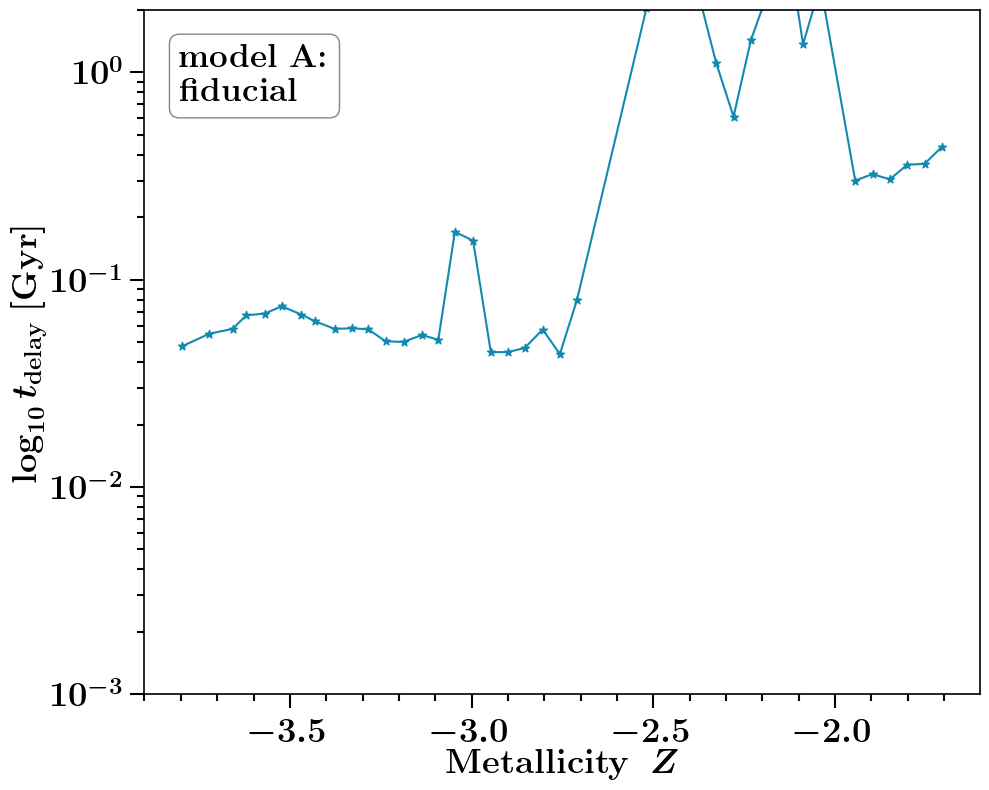

In [6]:
def plot_formation_channels_metallicity_xparam(axe='None', DCOtype='BHNS', \
                                          xparam='mass_tot', BPSmodelName='A', 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
#     param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    
    
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)
    elif xparam=='mass_tot':
        param_x = massCO_LVKM1 + massCO_LVKM2
        nameX = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,5,1000)
    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
    elif xparam=='mass_1_LVK':
        param_x = massCO_LVKM1
        nameX = r'$m_1 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-1,50,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
    elif xparam=='mass_2_LVK':
        param_x = massCO_LVKM2
        nameX = r'$m_2 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-2,5,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
            
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')    
    
    elif xparam=='t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)         
    
    

    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    metallicities = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    #     param_x = np.log10(param_x)
    

    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
        
        
        median_at_ZZ = np.zeros_like(np.unique(metallicities))
        
    #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
        for ind_Z, Zvalue in enumerate(np.unique(metallicities)):

            mask_ZZ = metallicities[mask_MRR]==Zvalue

            
            
            if len(weights_[mask_MRR][mask_ZZ])>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE



                if whichQuantity=='median':
                    median_at_ZZ[ind_Z] = weighted_quantile(values=param_x[mask_MRR][mask_ZZ], quantiles=[0.5], sample_weight=weights_[mask_MRR][mask_ZZ])
                    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                elif whichQuantity=='fraction':
                    mask_systems = param_x[mask_MRR][mask_ZZ] <= value_for_fraction
                    median_at_ZZ[ind_Z] = np.sum(weights_[mask_MRR][mask_ZZ][mask_systems])/np.sum(weights_[mask_MRR][mask_ZZ])
                    nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        
        mask_not_zero = (median_at_ZZ!=0)
        axe.scatter(np.log10(np.unique(metallicities))[mask_not_zero], median_at_ZZ[mask_not_zero], color=c_FC, marker=dictMarkerShape[BPSmodelName])
        axe.plot(np.log10(np.unique(metallicities))[mask_not_zero],    median_at_ZZ[mask_not_zero], color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




    
        




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{Metallicity} \ $Z$'
    ylabel = nameX
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
#     axe.set_xlim(0.001,0.3)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)

    if xparam in ['mass_tot']:
        axe.set_ylim(2, 4)        

        
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        if xparam in ['t_delay']:
            axe.set_yscale('log')
            axe.set_ylim(0.001, 2)
    
    
    
#     axe.set_xscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe




# plot delay times with fraction 




whichQuantity='median'
xparam = 't_delay'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BNS']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, xparam=xparam, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False) 



        
        
        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.png', transparent=False, dpi=300)
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    



# WORKING CODE 

In [28]:
def plot_formation_channels_redshift_rate_mssfr(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', redshifts=[0],\
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                  c_FC=False, mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                               weights_type='formation'):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
    
    
    param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    
    #     param_x = np.log10(param_x)
    
#     nameY = r'\textbf{PDF}'  
    xx = np.linspace(1,100,500)  
    print('obtained params')   
    
    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
    
        if np.sum(mask_MRR)>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE
        #     if mask_specific_mssfr==None:
        #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
            for ind_mssfr, mssfr in enumerate(MSSFRnameslist[0:]):
                print(mssfr)

                median_at_redshifts = np.zeros_like(redshifts_runs)

                for z_ind, redshift in enumerate(redshifts_runs[0:]):
                    redshift = np.round(redshift,4)
                    
                    if weights_type=='merger':
                        fparam_key = 'weights_intrinsicPerRedshift'
                        weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                        weights_ = fdata[fparam_key][weightheader][...].squeeze()
                    elif weights_type=='formation':
                        fparam_key = "weights_intrinsicFormationPerRedshift"
                        weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                        weights_ = fdata[fparam_key][weightheader][...].squeeze()
                    
                
#                     fparam_key = "weights_intrinsicFormationPerRedshift"
# #                     fparam_key = 'weights_intrinsicPerRedshift'
#                     weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
#                     weights_ = fdata[fparam_key][weightheader][...].squeeze()



                    if whichQuantity=='median':
                        median_at_redshifts[z_ind] = weighted_quantile(values=param_x[mask_MRR], quantiles=[0.5], sample_weight=weights_[mask_MRR])
                        nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                    elif whichQuantity=='fraction':
                        mask_systems = param_x[mask_MRR] <= value_for_fraction
                        median_at_redshifts[z_ind] = np.sum(weights_[mask_MRR][mask_systems])/np.sum(weights_[mask_MRR])
                        nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        

                axe.scatter(redshifts[:], median_at_redshifts, color=c_FC, marker=dictMarkerShape[BPSmodelName])
                axe.plot(redshifts[:],    median_at_redshifts, color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




    
        




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{redshift} $z$'
    ylabel = nameY
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
    axe.set_xlim(0,9.6)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        axe.set_yscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe




at BPS model  F

at DCOtype = BHNS
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


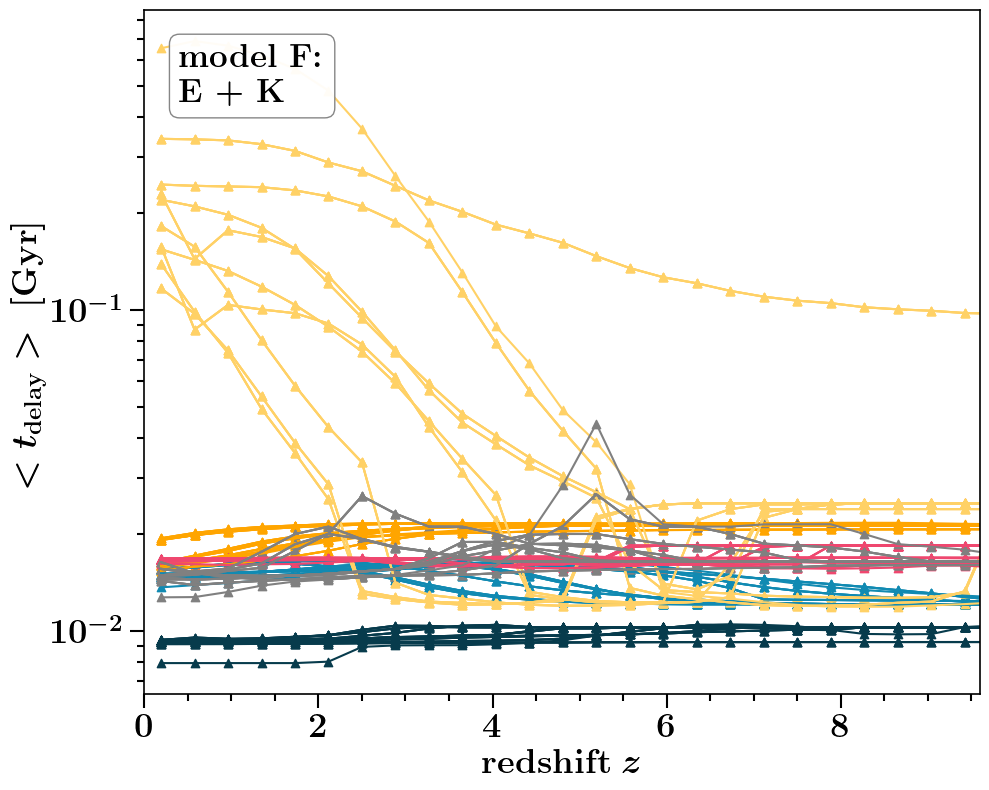


at DCOtype = BBH
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


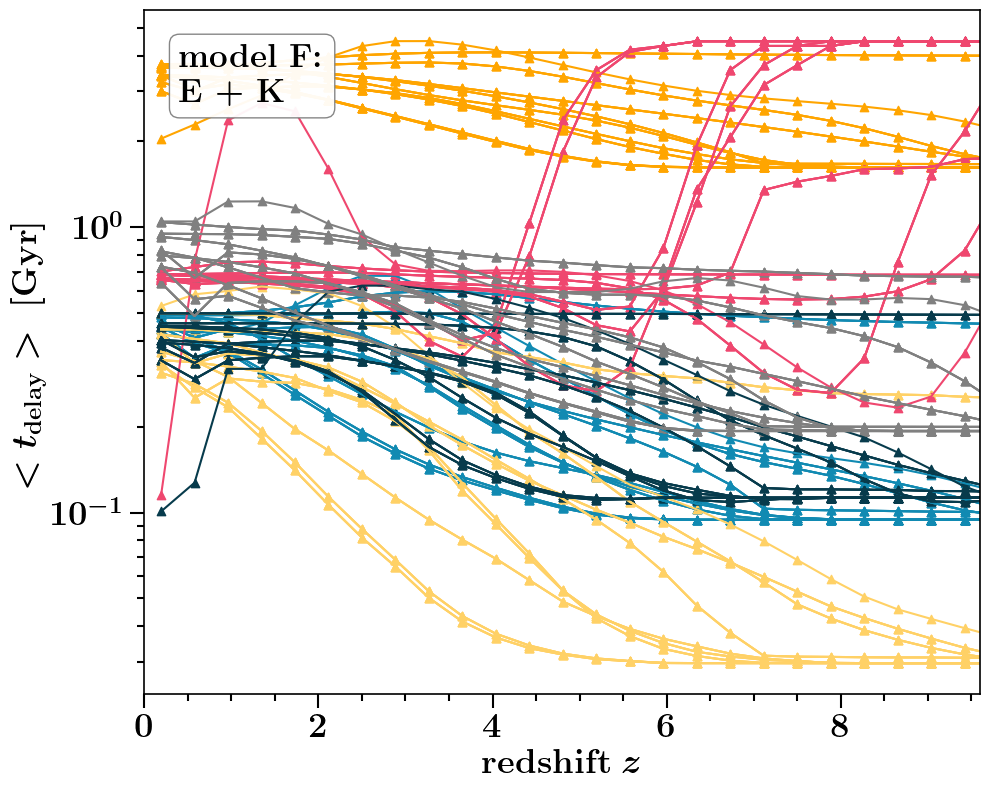

at BPS model  G

at DCOtype = BHNS
obtained params
000
111


/Users/floorbroekgaarden/Projects/GitHub/DCO_FormationChannels/plottingCode/Figure_Redshift_Rates/../../../common_code/PostProcessingScripts.py:1112: RuntimeWarning: invalid value encountered in divide
  weighted_quantiles /= np.sum(sample_weight)


112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


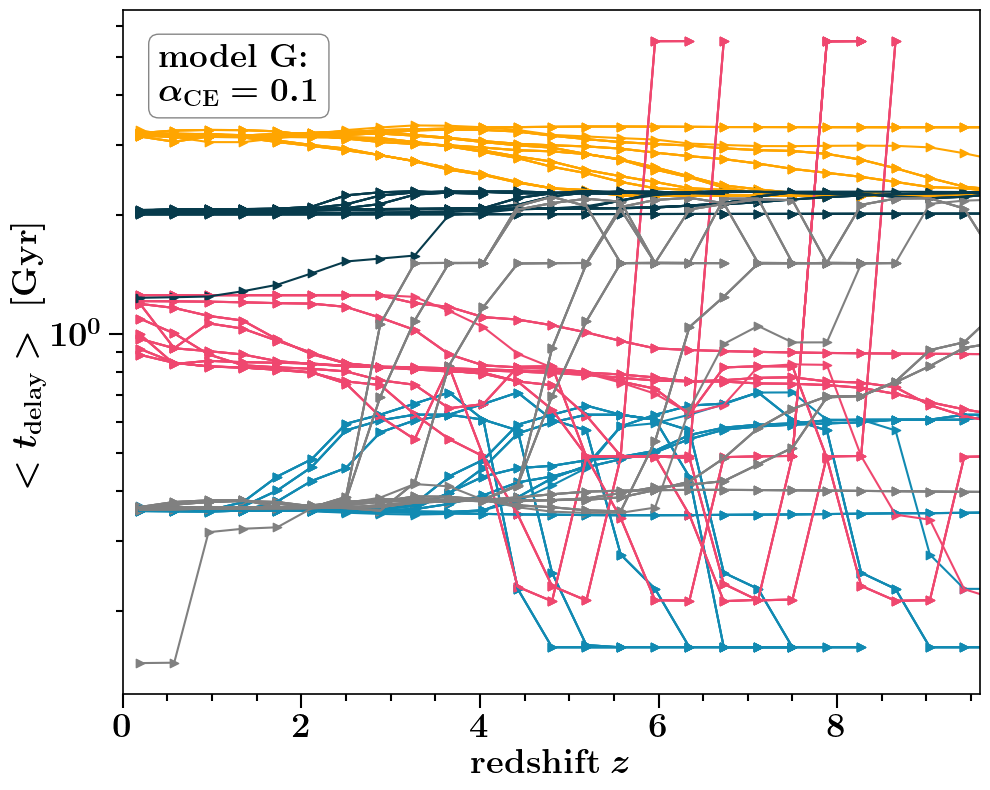


at DCOtype = BBH
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


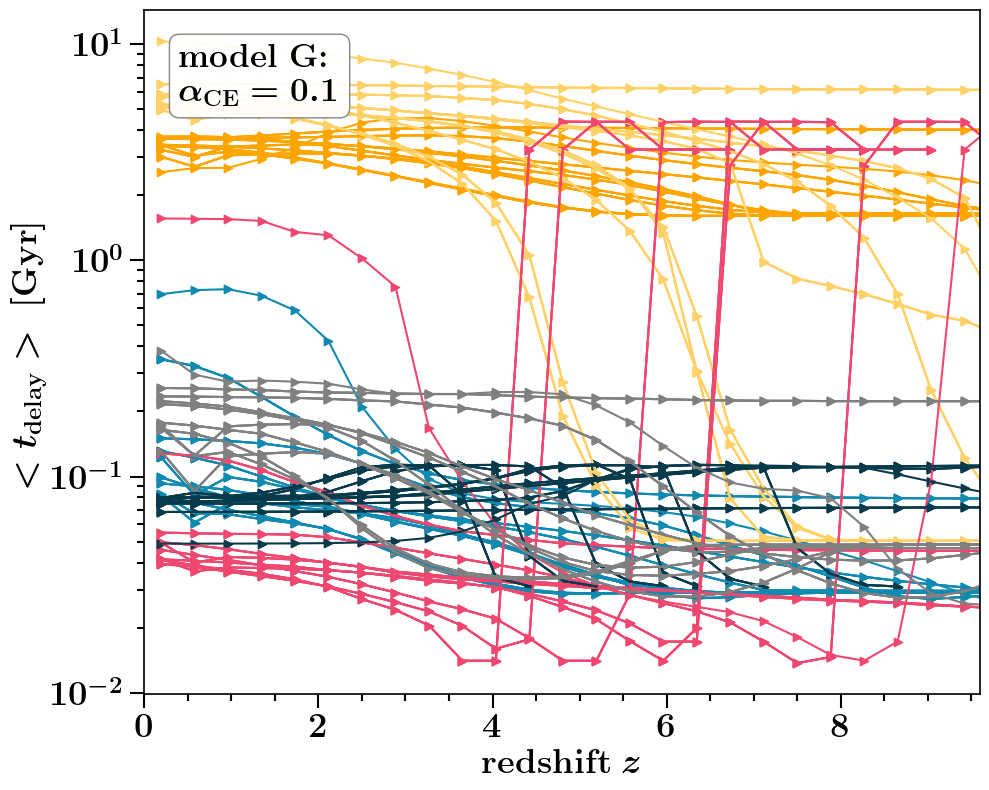

at BPS model  H

at DCOtype = BHNS
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


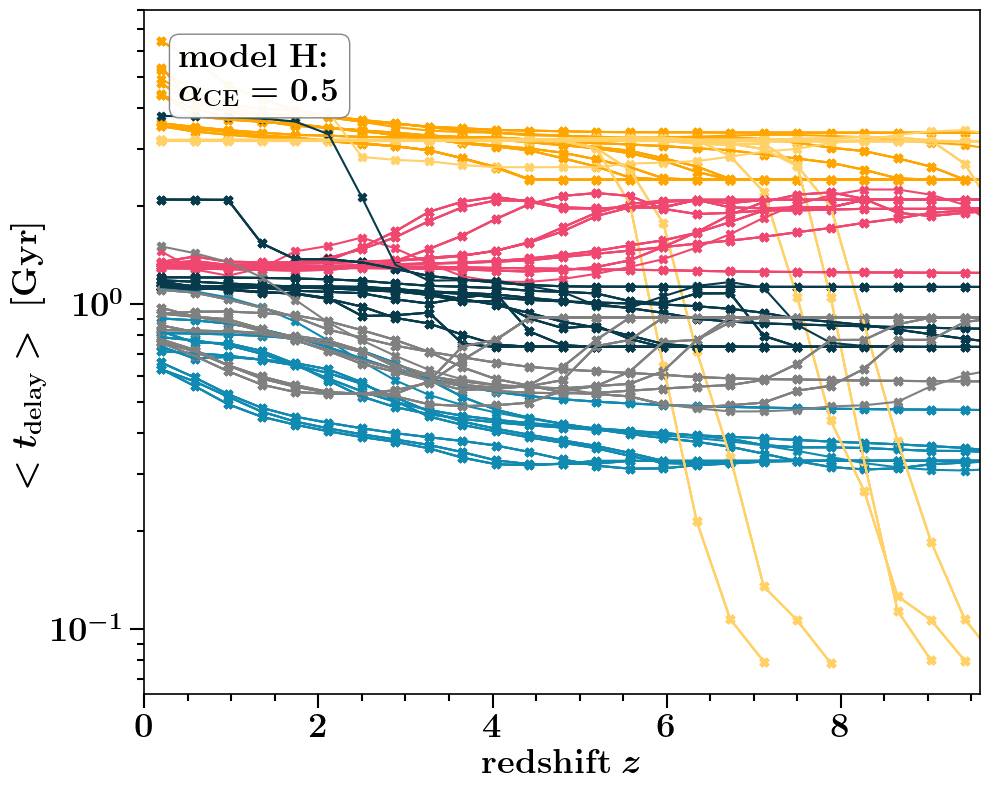


at DCOtype = BBH
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


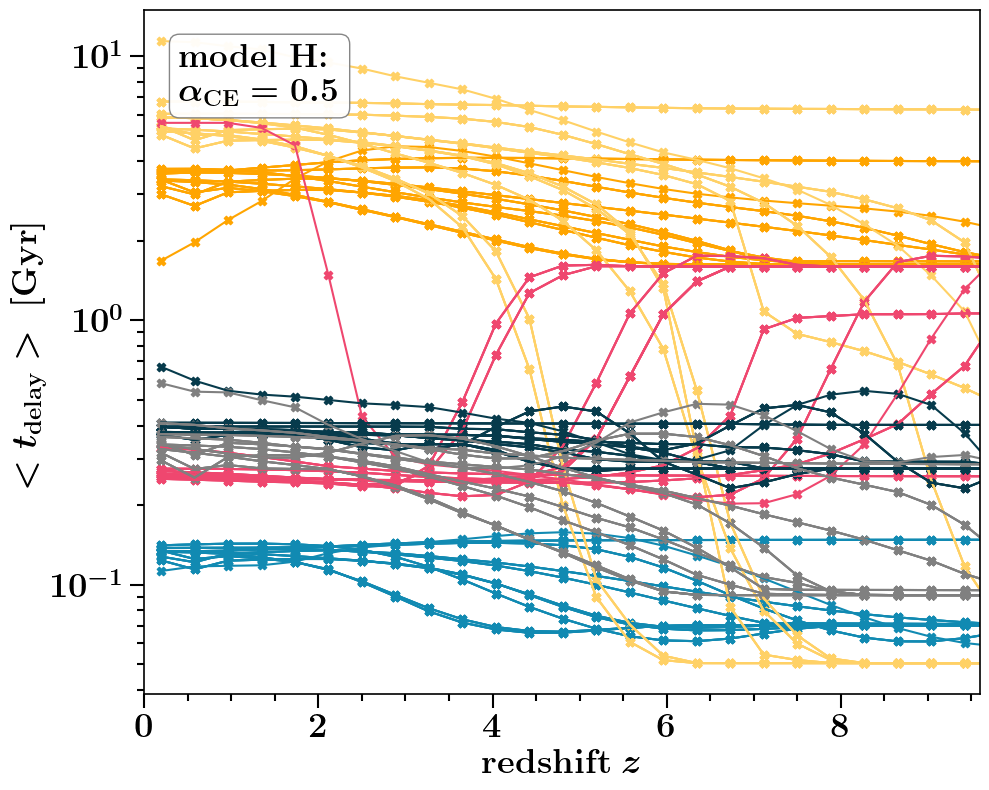

at BPS model  I

at DCOtype = BHNS
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


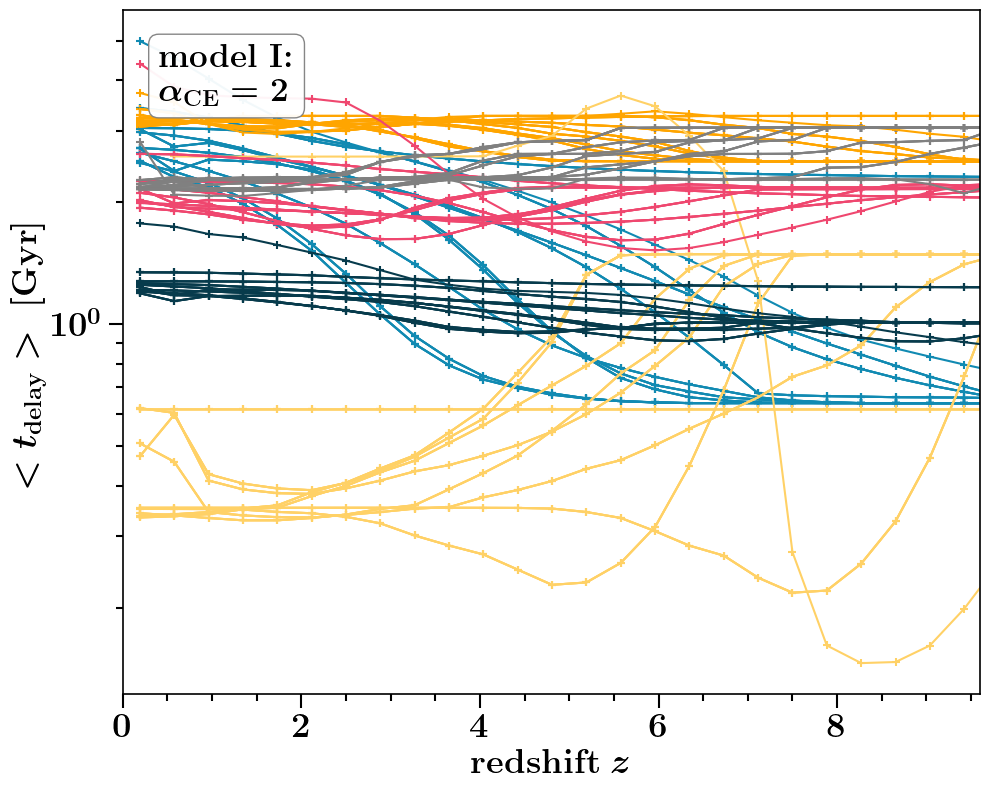


at DCOtype = BBH
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


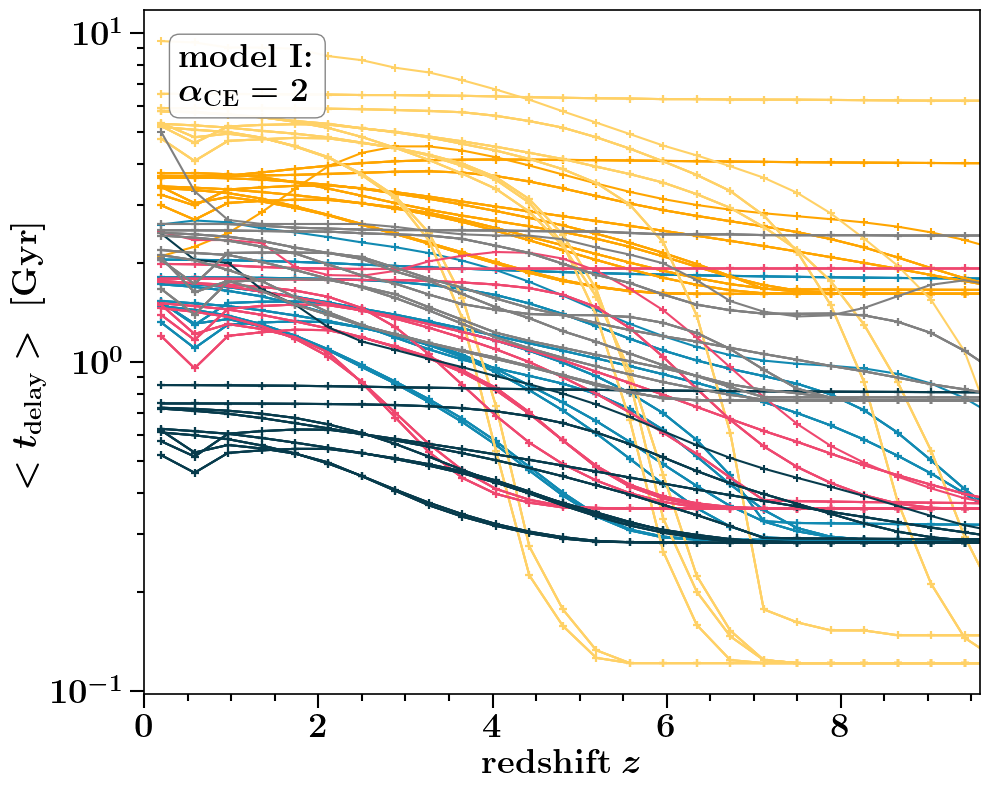

at BPS model  J

at DCOtype = BHNS
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


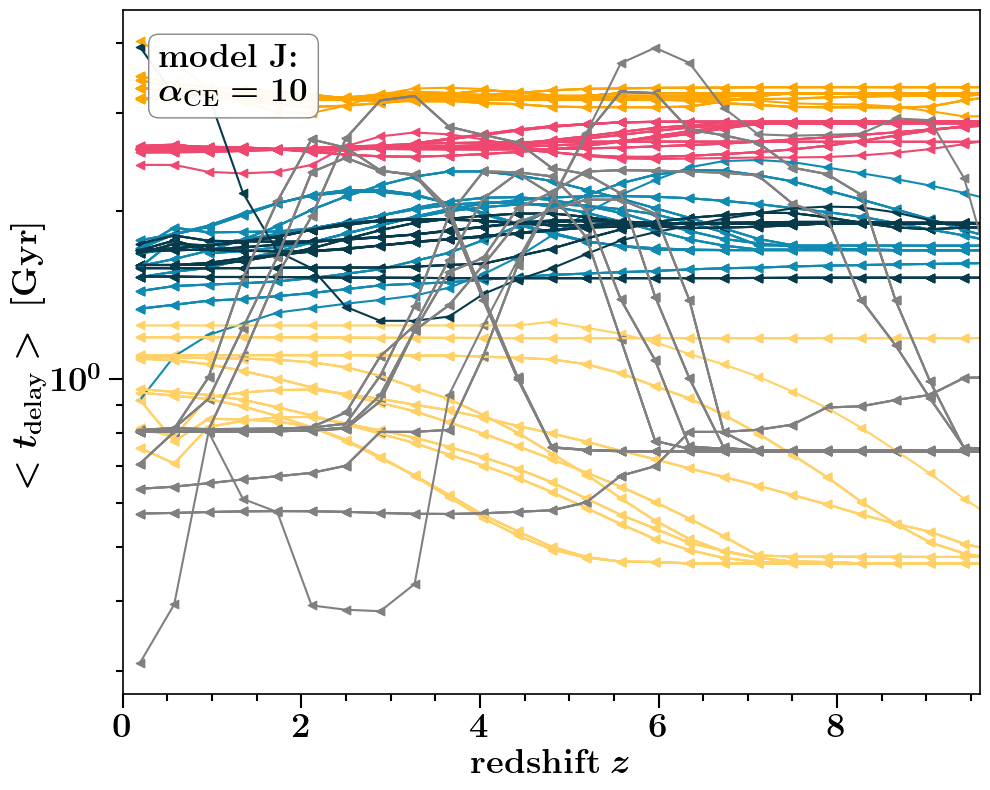


at DCOtype = BBH
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333


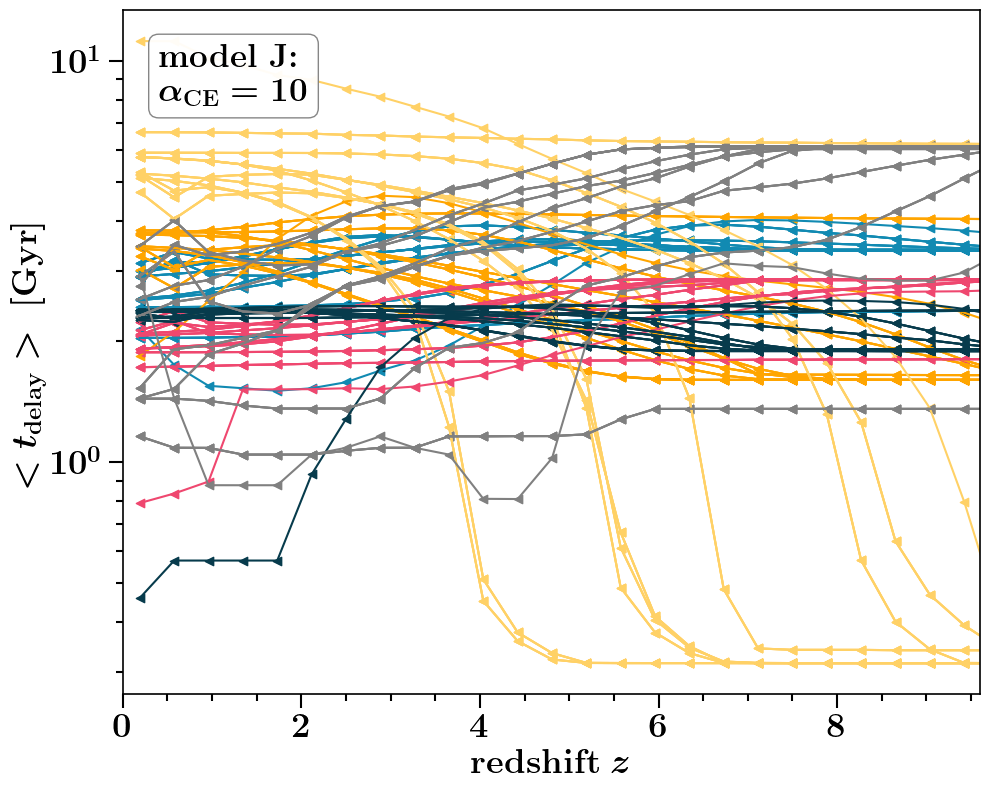

at BPS model  K

at DCOtype = BHNS
obtained params
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213
221
222
223
231
232
233
311
312
313
321
322
323
331
332
333
000
111
112
113
121
122
123
131
132
133
211
212
213


KeyboardInterrupt: 

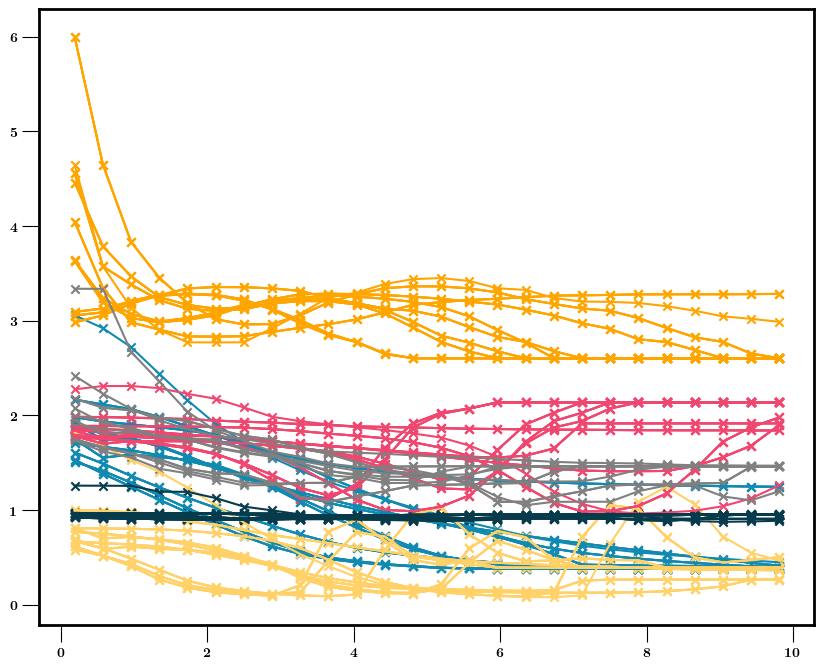

In [29]:
# plot delay times with fraction 



weights_type='formation'
whichQuantity='median'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[5:]):
    color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in [ 'BHNS', 'BBH']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_redshift_rate_mssfr(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              redshifts=redshifts_runs, pathData=pathData,\
                                                            c_FC=color_m, mask_specific_mssfr='x',\
                                                         whichQuantity=whichQuantity, value_for_fraction=0.1,\
                                                        weights_type=weights_type) 


        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/delay_time/delay_time_ratesz_' +  DCOtype + '_' + BPSmodelName + '_' + weights_type + '_' + whichQuantity + '.png', transparent=False)
        plt.savefig('./formation_median/delay_time/delay_time_ratesz_' +  DCOtype + '_' + BPSmodelName + '_' + weights_type + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    

In [ ]:
# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist):
    color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in [ 'BNS']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_redshift_rate_mssfr(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              redshifts=redshifts_runs, pathData=pathData,\
                                                            c_FC=color_m, mask_specific_mssfr='x', whichRate='channeltotal') 


        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/delay_time/delay_time_ratesz_' +  DCOtype + '_' + BPSmodelName + '.png', transparent=False)
        plt.savefig('./formation_median/delay_time/delay_time_ratesz_' +  DCOtype + '_' + BPSmodelName + '.pdf', transparent=False)
        plt.show()
        plt.close()


In [ ]:
DCOtype='BNS'



pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
DCOname = DCOname_dict[DCOtype]





for ind_bps, BPSmodelName in enumerate(BPSnameslist):
    
    ncols, nrows= 1,1
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    fdata = h5.File(full_data_path,'r')

    # get the redshifts
    redshifts = redshifts_runs


    for ind_mssfr, mssfr in enumerate([MSSFRnameslist[1]]):
#     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:2]):
        print('mssfr', mssfr)

        rates_at_redshifts = np.zeros_like(redshifts_runs)
        rates_at_redshifts_form = np.zeros_like(redshifts_runs)


        for z_ind, redshift in enumerate(redshifts_runs[0:]):
            print(redshift)
            redshift = np.round(redshift,4)
            fparam_key = "weights_intrinsicFormationPerRedshift"

            weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
            weights_form = fdata[fparam_key][weightheader][...].squeeze()

            fparam_key = 'weights_intrinsicPerRedshift'
            weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
            weights_ = fdata[fparam_key][weightheader][...].squeeze()

            rates_at_redshifts[z_ind] = np.sum(weights_)
            rates_at_redshifts_form[z_ind] = np.sum(weights_form)

        axe.scatter(redshifts[:], rates_at_redshifts, color='blue')
        axe.plot(redshifts[:],    rates_at_redshifts, color='blue') #, ls=linestyles_mssfrind[ind_mssfr_zind])

        axe.scatter(redshifts[:], rates_at_redshifts_form, color='orange')
        axe.plot(redshifts[:],    rates_at_redshifts_form, color='orange') #, ls=linestyles_mssfrind[ind_mssfr_zind])

        
        
        
        
    axe.set_yscale('log')
        
    plt.show()
    fdata.close()


In [ ]:
fdata.close()

In [ ]:
DCOtype='BNS'



pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
DCOname = DCOname_dict[DCOtype]


for BPSmodelName in BPSnameslist[0:3]:


    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    # read in data 
    fdata = h5.File(full_data_path,'r')
    print()
    print('BPS ' , BPSmodelName)
    
    
    print(fdata['weights_intrinsicFormationPerRedshift'].keys())

    fdata.close()







In [ ]:
MassEvolved = [77598406.21327497, 77598095.82151248, 77598483.8112156, 77598018.22357185
, 77598328.61533435, 77598483.8112156, 77598483.8112156, 77598018.22357185
, 77598095.82151248, 77598483.8112156, 77598561.40915622, 77598173.4194531
, 77598328.61533435, 77598561.40915622, 77598483.8112156, 77598406.21327497
, 77598095.82151248, 77598018.22357185, 77598406.21327497, 77598639.00709686
, 77598639.00709686, 77598406.21327497, 77598639.00709686, 77598483.8112156
, 77598483.8112156, 77598095.82151248, 77598251.01739372, 77598483.8112156
, 77598483.8112156, 77598251.01739372, 77598173.4194531, 77597940.62563121
, 77598251.01739372, 77598483.8112156, 77598095.82151248, 77598561.40915622
, 77598173.4194531, 77598328.61533435, 77598561.40915622, 77598406.21327497
, 77598173.4194531, 77598406.21327497, 77598173.4194531, 77598251.01739372
, 77598173.4194531, 77598095.82151248, 77597940.62563121, 77598095.82151248
, 77598406.21327497, 77598561.40915622, 77598639.00709686, 77598173.4194531
, 77598095.82151248]

print(np.mean(MassEvolved))
print(np.median(MassEvolved))

## Plot median delay times as a function of metallicity

In [12]:
def plot_formation_channels_metallicity_xparam(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                              add_model_label=True):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other'
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
    param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    metallicities = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    #     param_x = np.log10(param_x)
    

    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
        
        
        median_at_ZZ = np.zeros_like(np.unique(metallicities))
        
    #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
        for ind_Z, Zvalue in enumerate(np.unique(metallicities)):

            mask_ZZ = metallicities[mask_MRR]==Zvalue

            
            
            if len(weights_[mask_MRR][mask_ZZ])>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE



                if whichQuantity=='median':
                    median_at_ZZ[ind_Z] = weighted_quantile(values=param_x[mask_MRR][mask_ZZ], quantiles=[0.5], sample_weight=weights_[mask_MRR][mask_ZZ])
                    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                elif whichQuantity=='fraction':
                    mask_systems = param_x[mask_MRR][mask_ZZ] <= value_for_fraction
                    median_at_ZZ[ind_Z] = np.sum(weights_[mask_MRR][mask_ZZ][mask_systems])/np.sum(weights_[mask_MRR][mask_ZZ])
                    nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        

        axe.scatter(np.log10(np.unique(metallicities)), median_at_ZZ, color=c_FC, marker=dictMarkerShape[BPSmodelName])
        axe.plot(np.log10(np.unique(metallicities)),    median_at_ZZ, color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




    
        




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{Metallicity} \ $Z$'
    ylabel = nameY
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
#     axe.set_xlim(0.001,0.3)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        axe.set_yscale('log')
    
#     axe.set_xscale('log')
    
    if add_model_label==True:
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
        axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                     xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                    zorder=1E10)

    return axe




at BPS model  A

at DCOtype = BBH


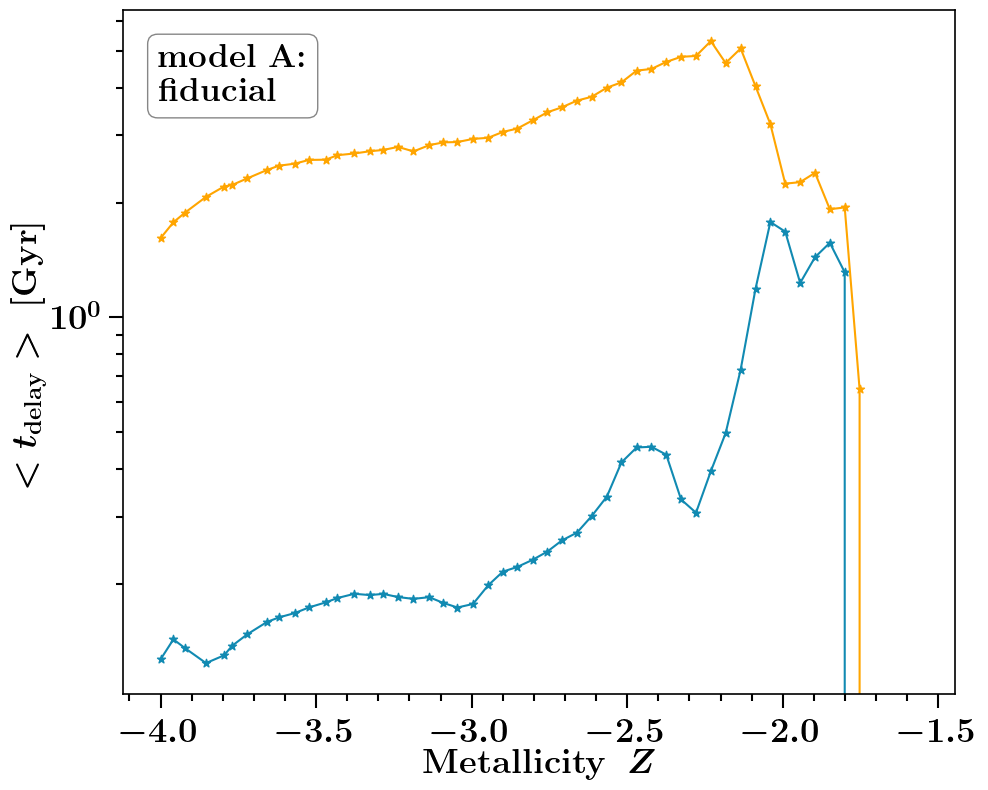

at BPS model  B

at DCOtype = BBH


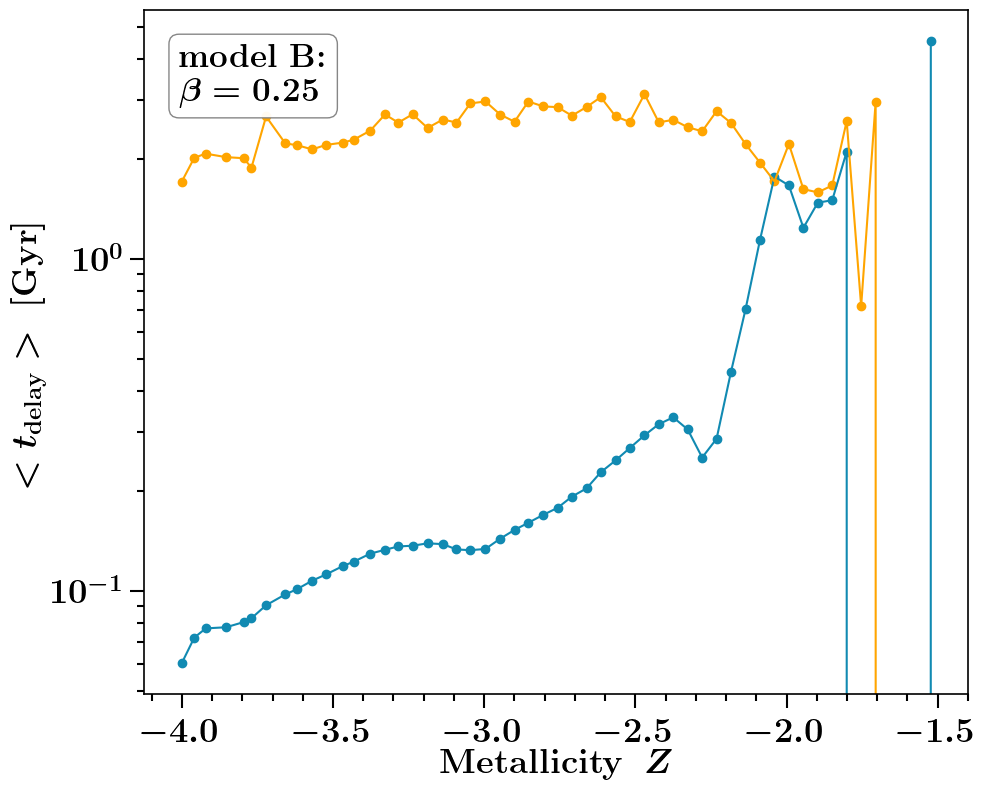

at BPS model  C

at DCOtype = BBH


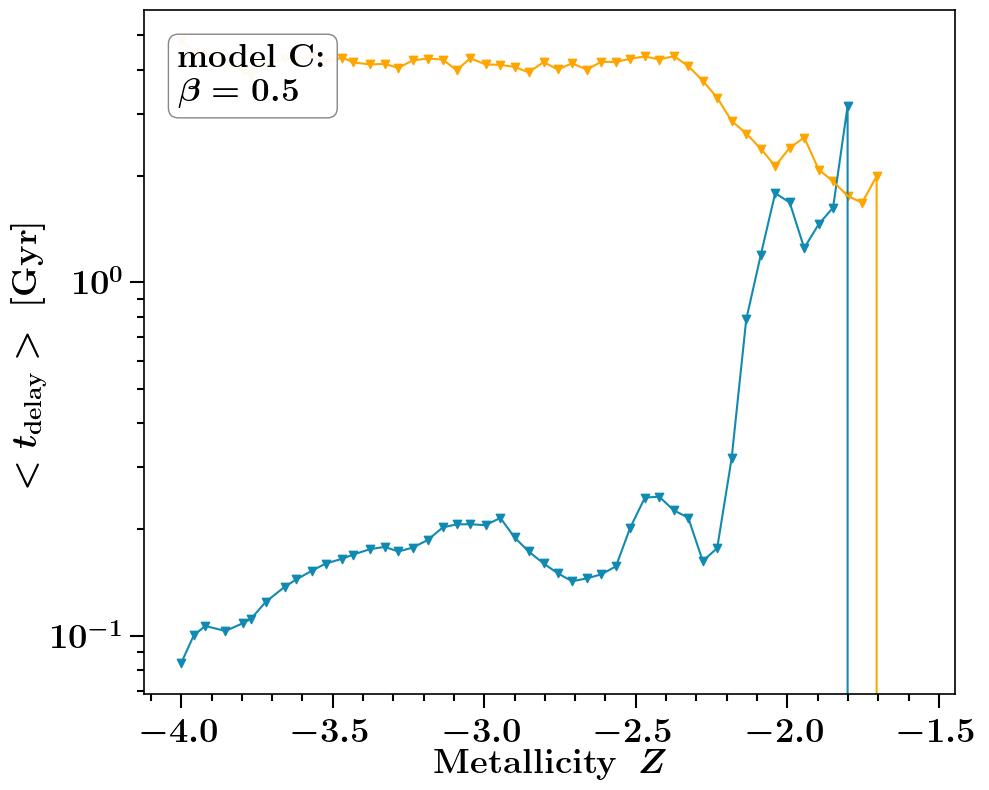

at BPS model  D

at DCOtype = BBH


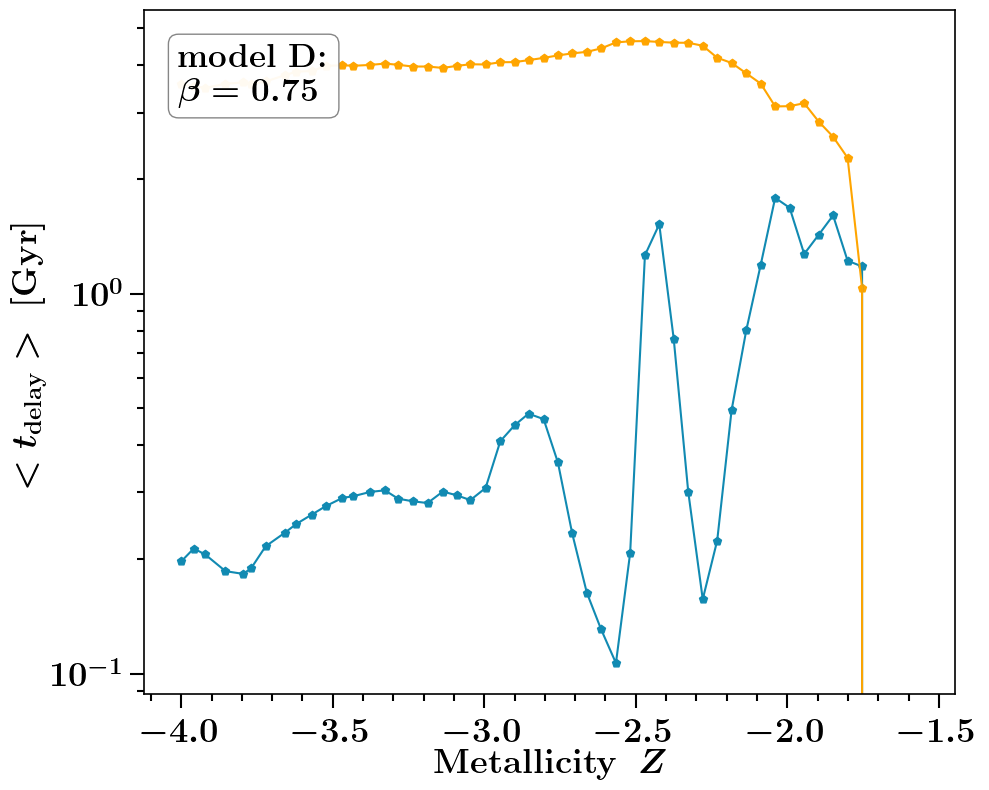

at BPS model  E

at DCOtype = BBH


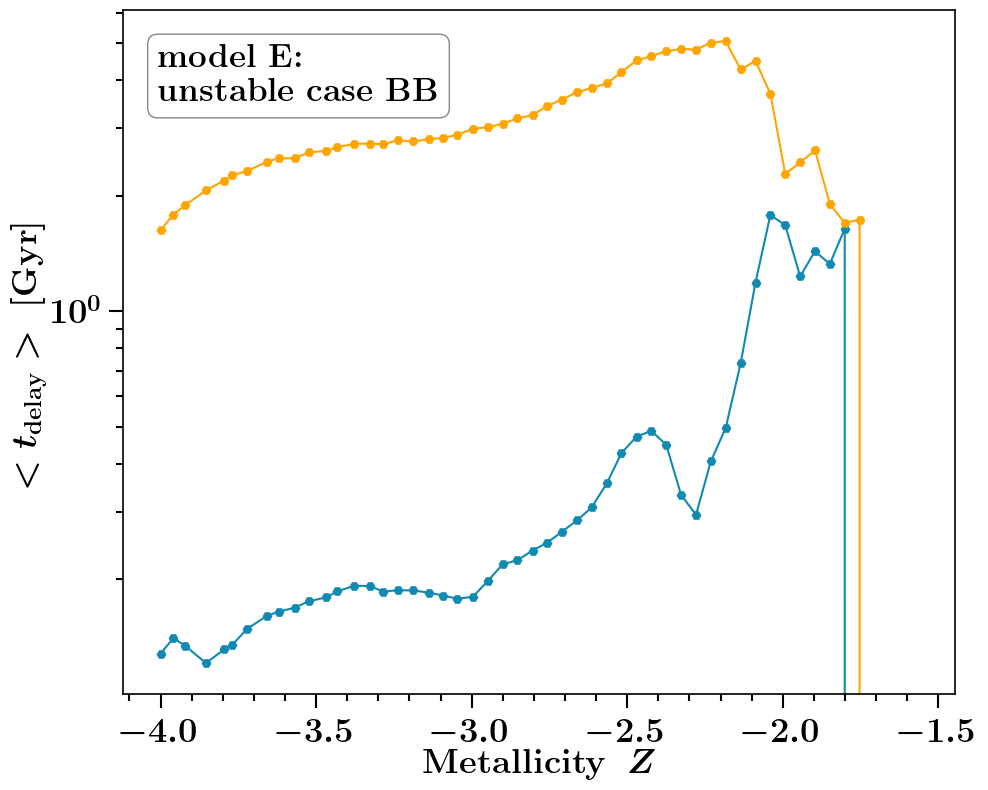

at BPS model  F

at DCOtype = BBH


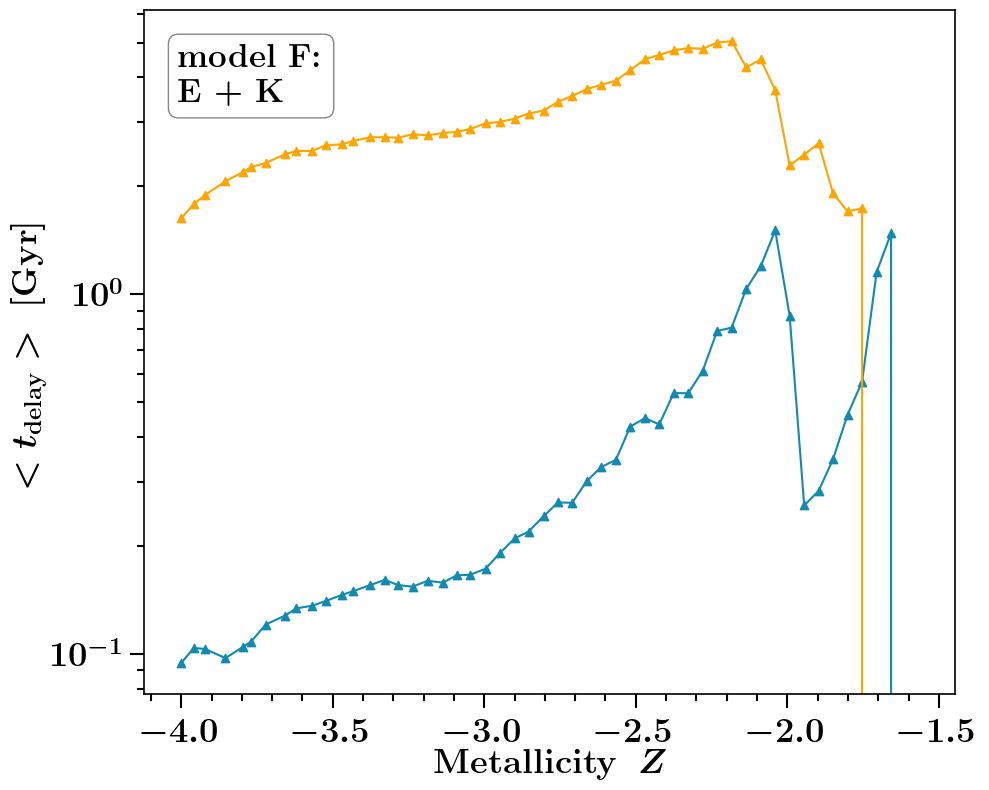

at BPS model  G

at DCOtype = BBH


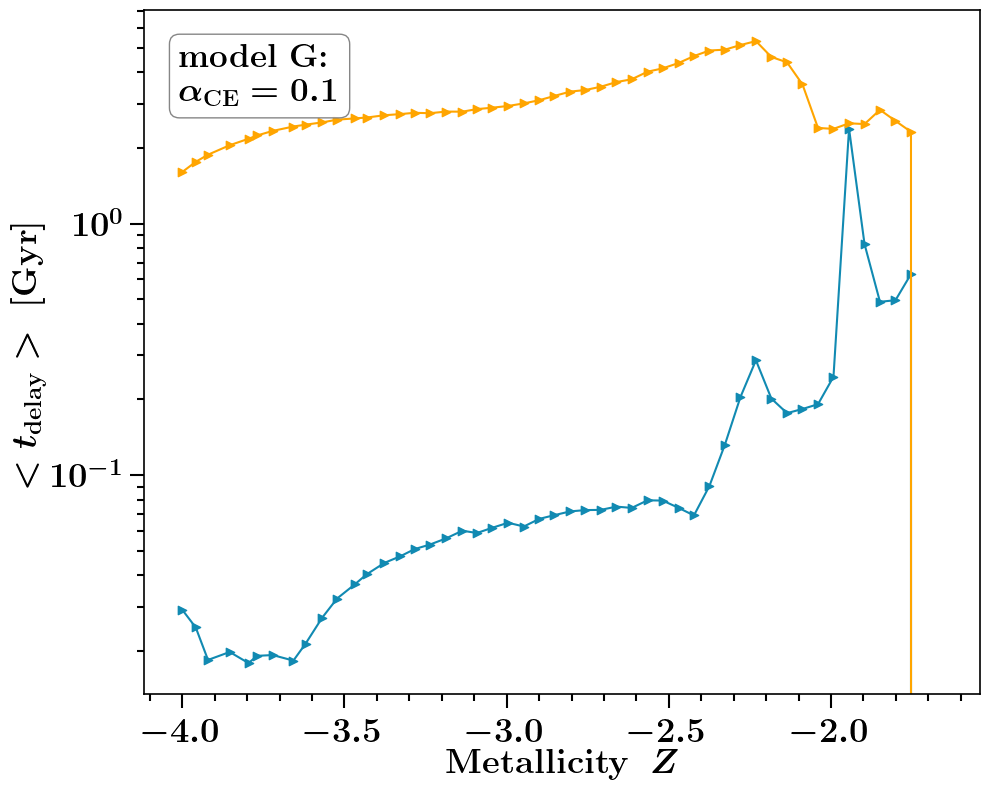

at BPS model  H

at DCOtype = BBH


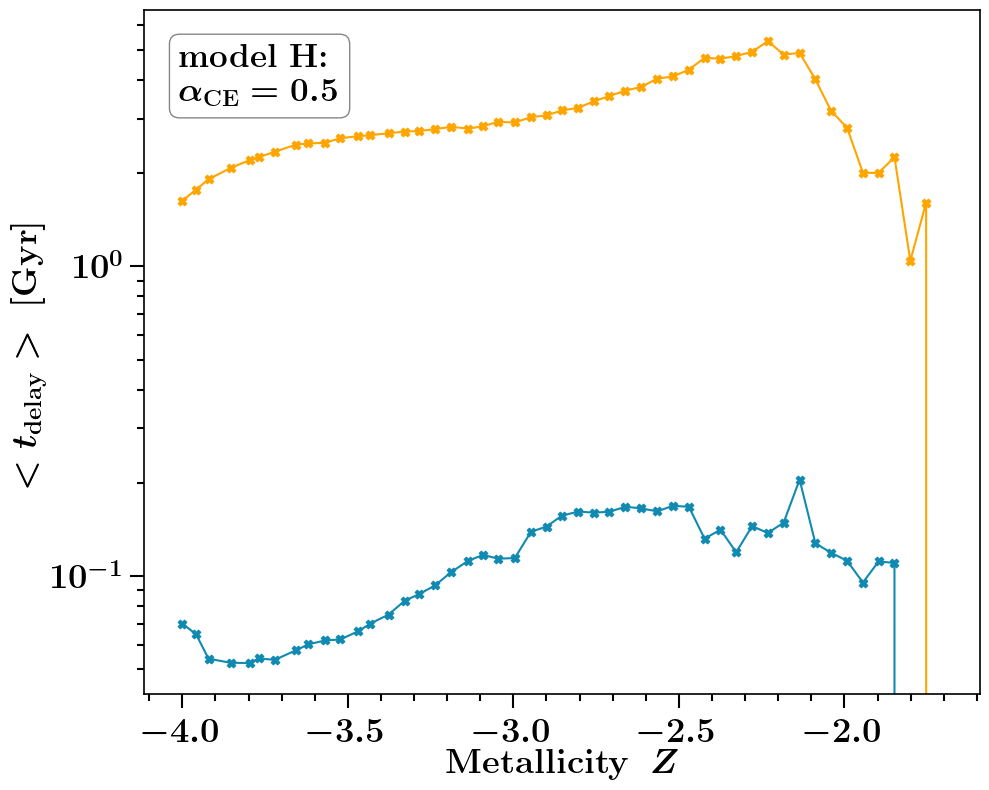

at BPS model  I

at DCOtype = BBH


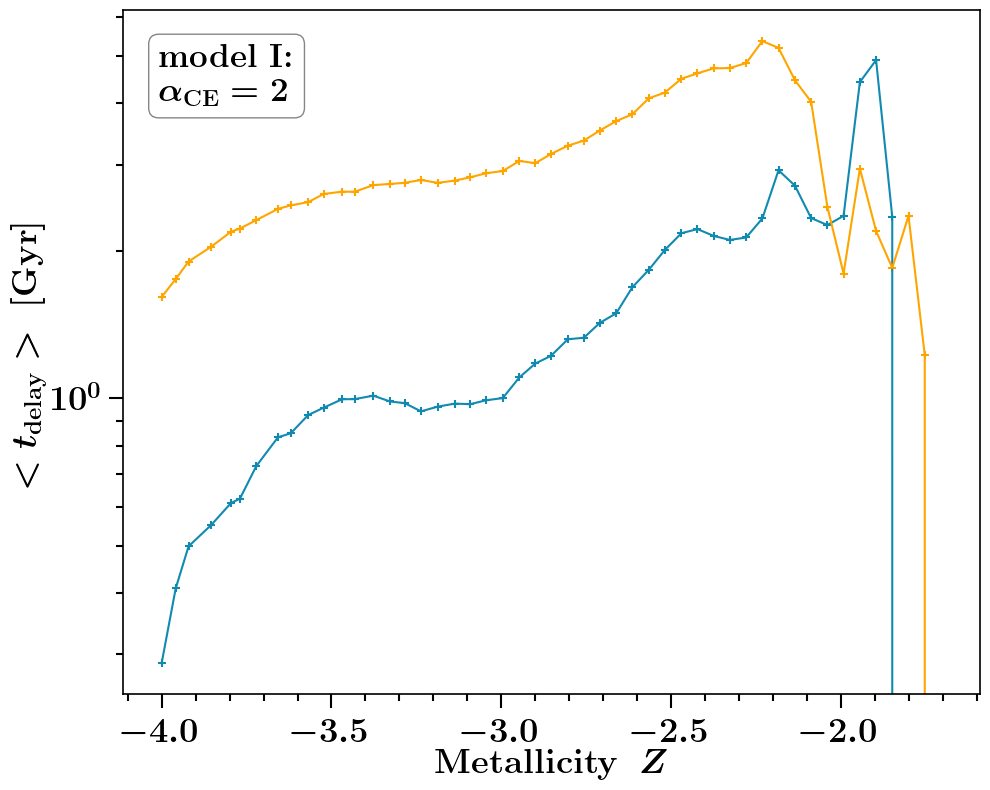

at BPS model  J

at DCOtype = BBH


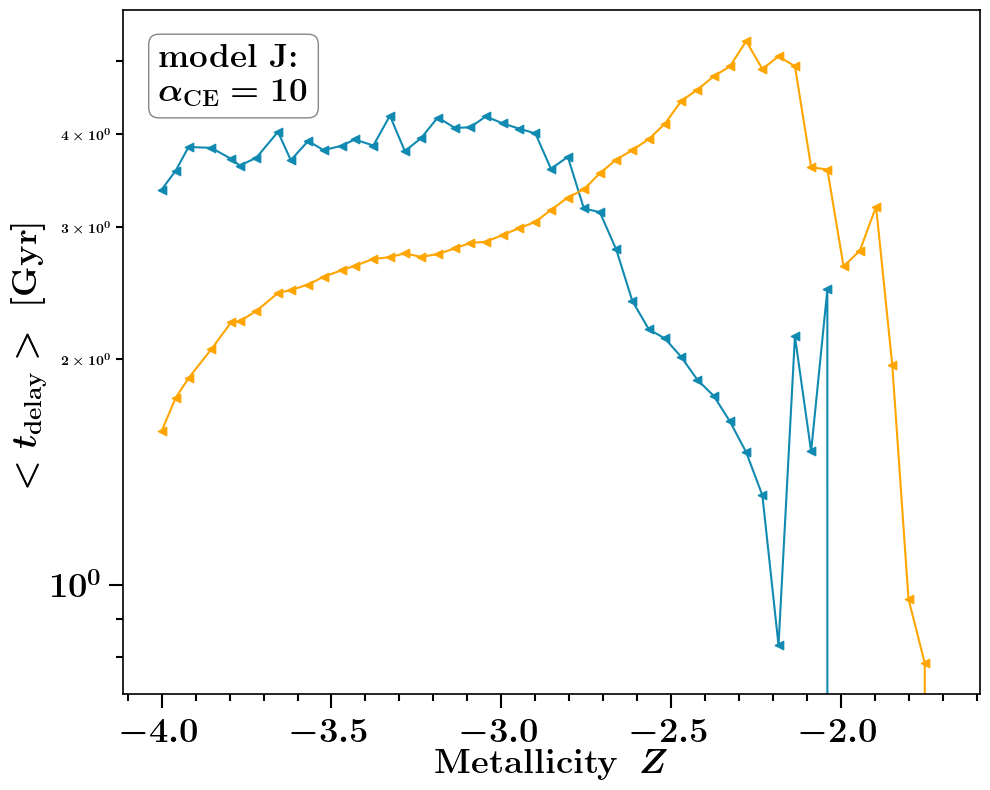

at BPS model  K

at DCOtype = BBH


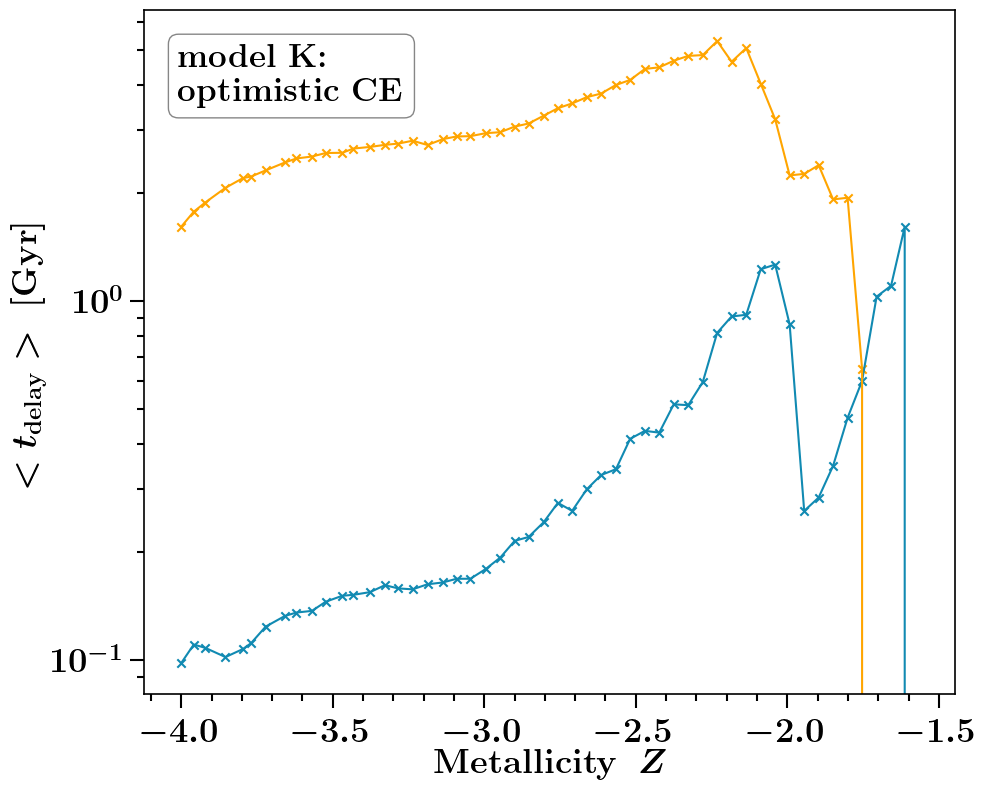

at BPS model  L

at DCOtype = BBH


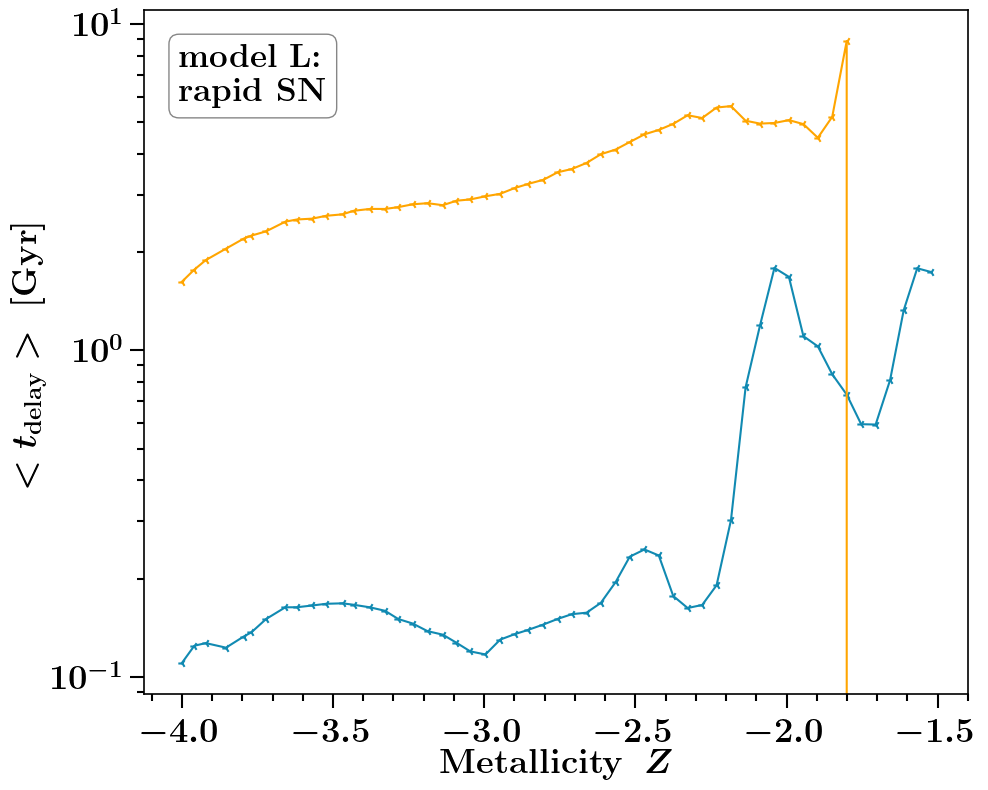

at BPS model  M

at DCOtype = BBH


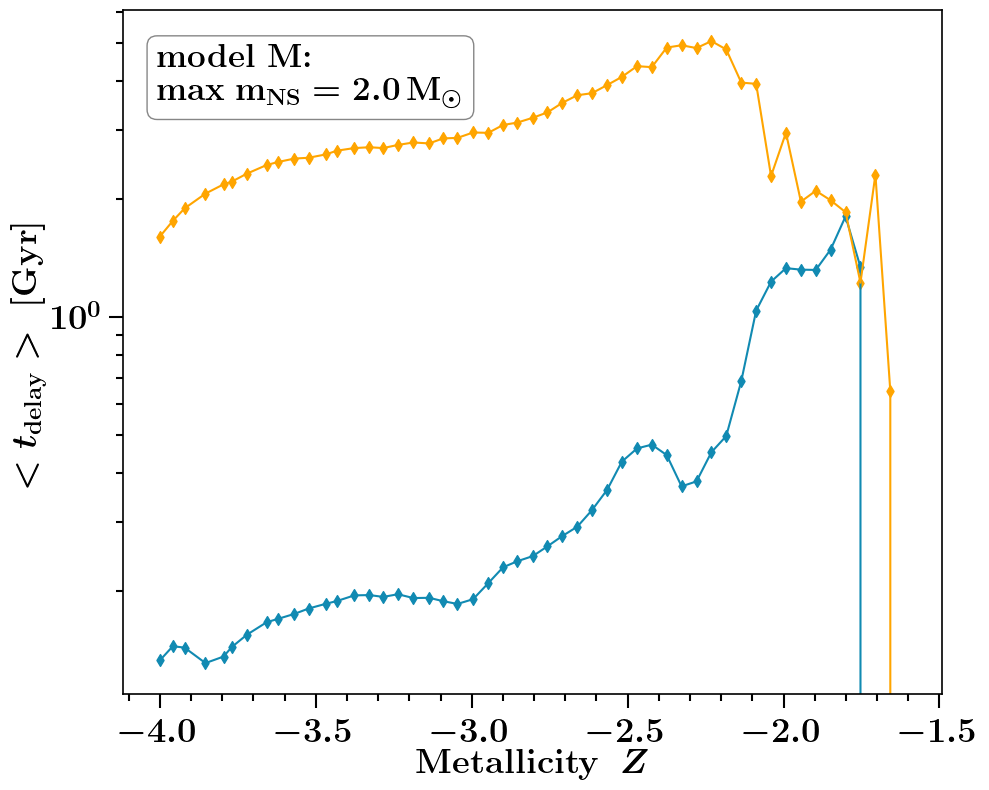

at BPS model  N

at DCOtype = BBH


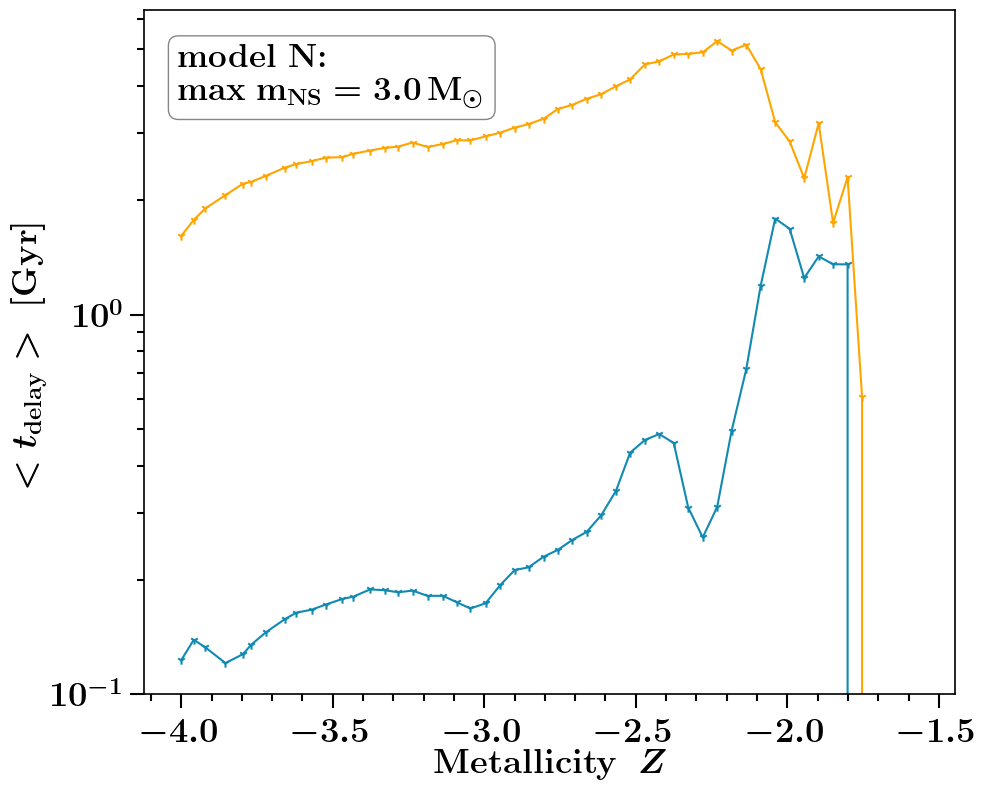

at BPS model  O

at DCOtype = BBH


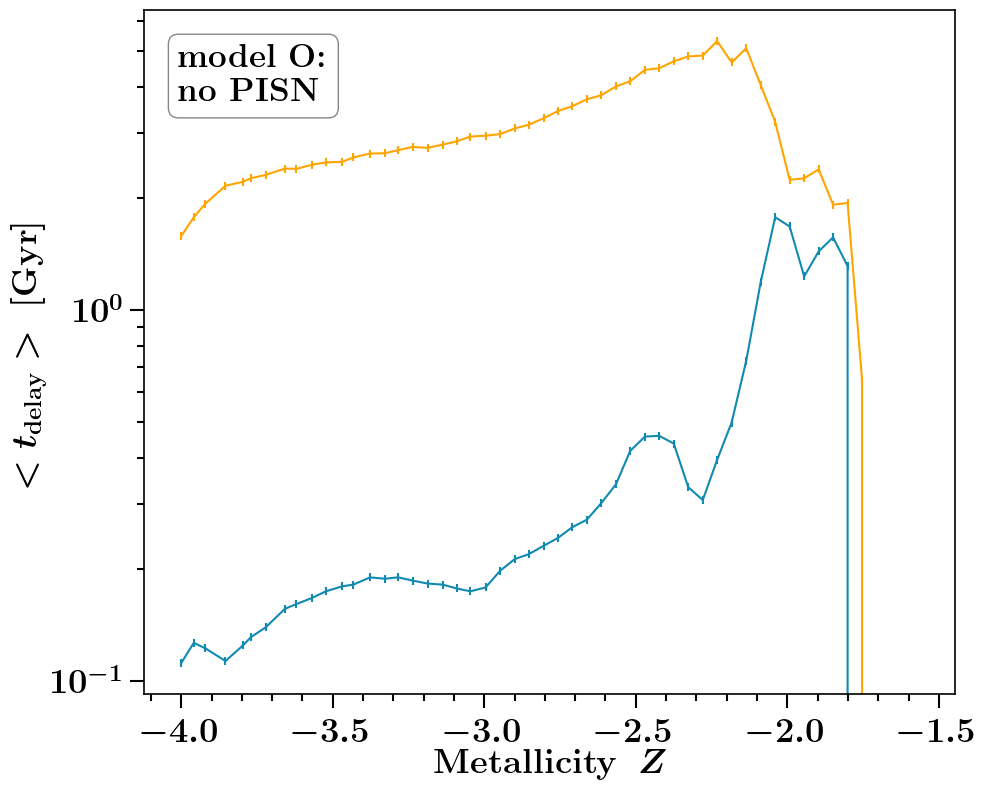

at BPS model  P

at DCOtype = BBH


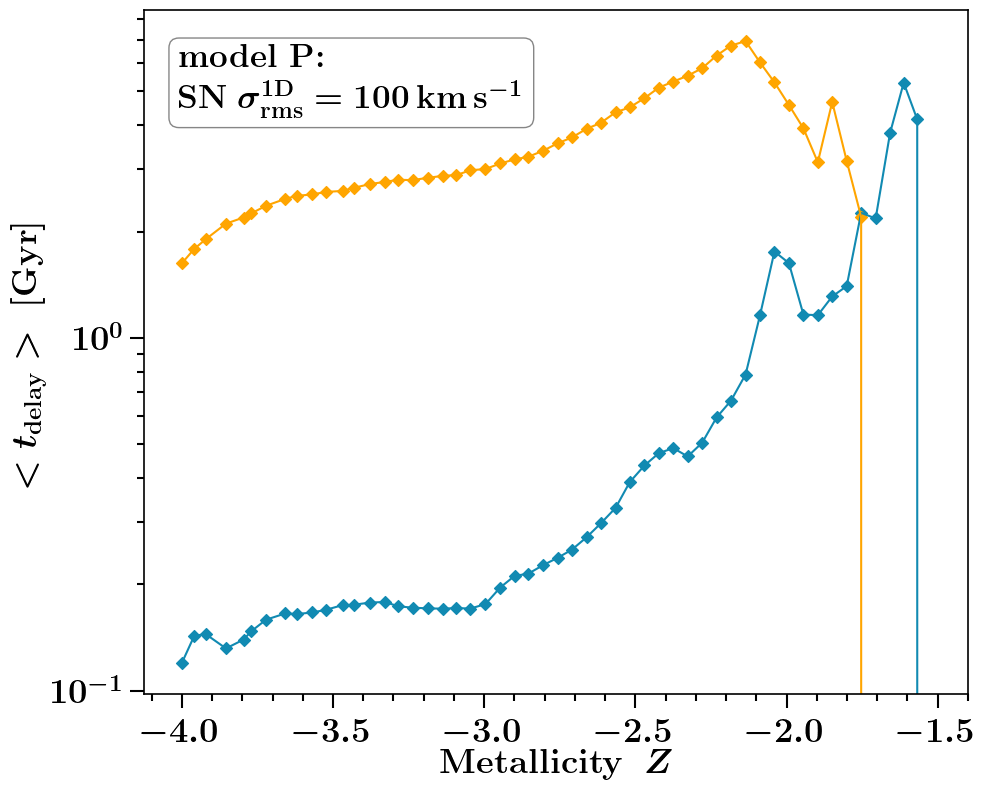

at BPS model  Q

at DCOtype = BBH


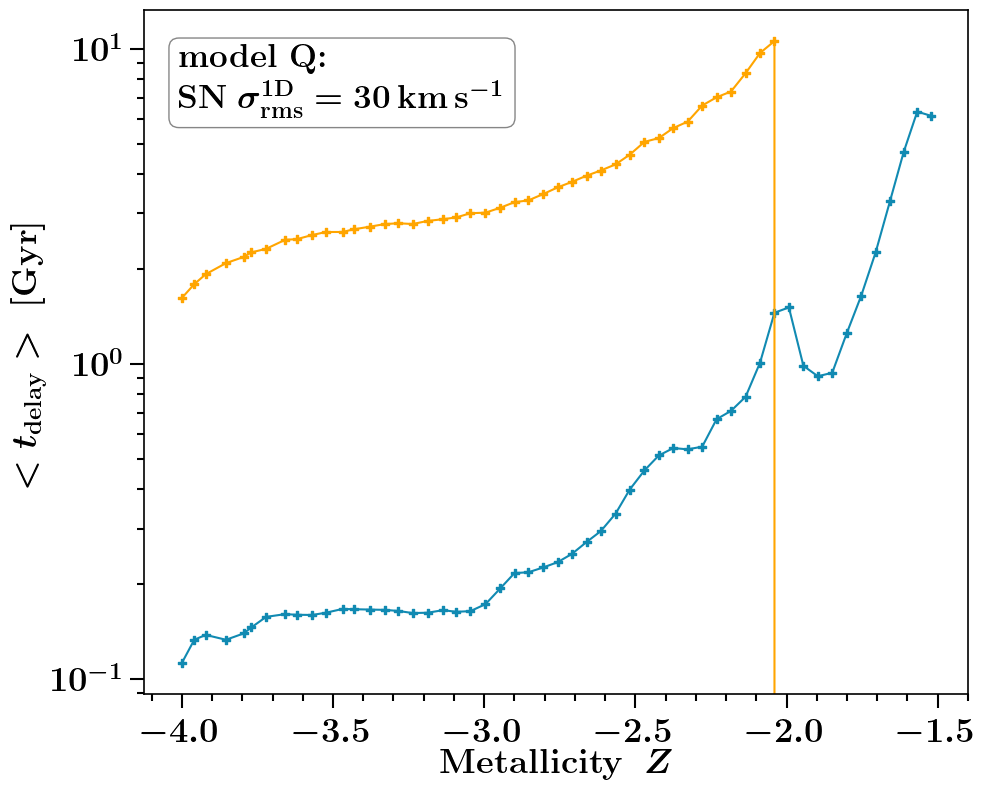

at BPS model  R

at DCOtype = BBH


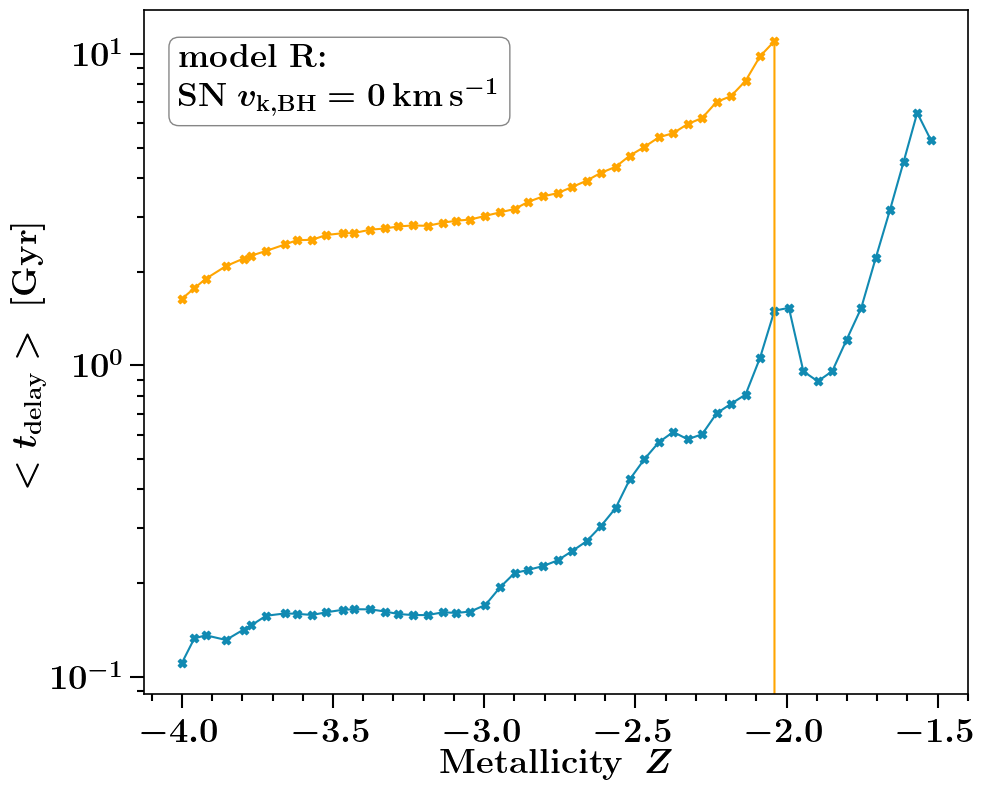

at BPS model  S

at DCOtype = BBH


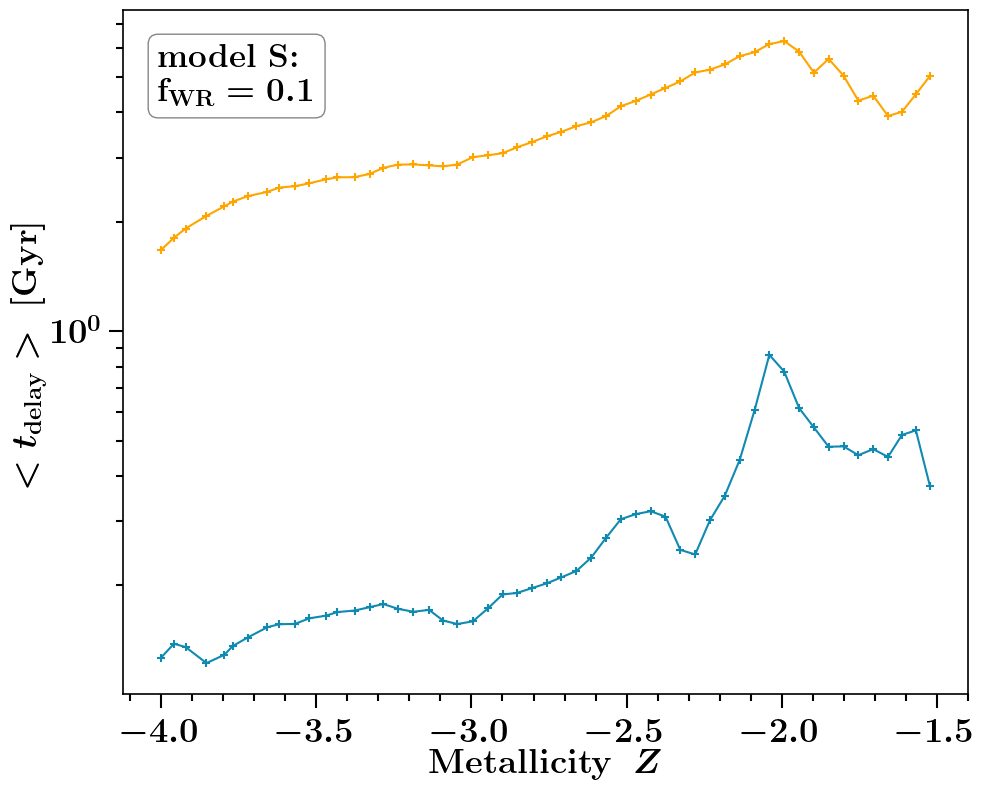

at BPS model  T

at DCOtype = BBH


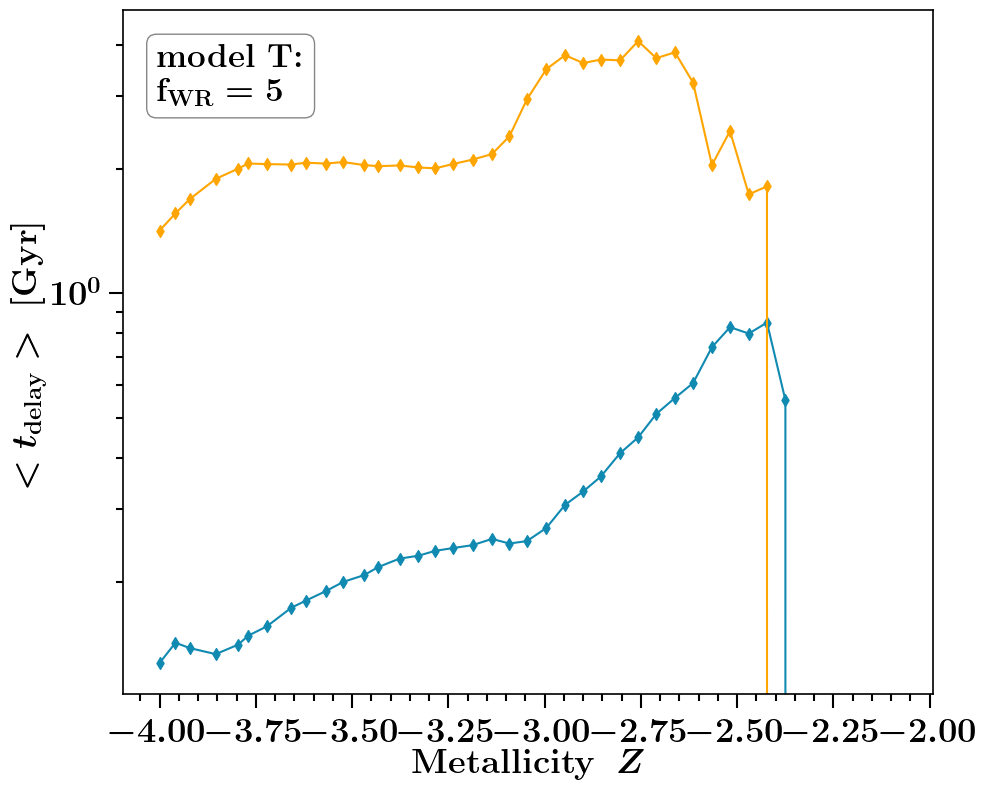

In [14]:
# plot delay times with fraction 




whichQuantity='median'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BBH']: #'BNS', 'BHNS', 
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False, add_model_label=True) 



        
        
        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.png', transparent=False, dpi=300)
        plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    

## all in one figure 

at BPS model  A

at DCOtype = BBH
at BPS model  B

at DCOtype = BBH
at BPS model  C

at DCOtype = BBH
at BPS model  D

at DCOtype = BBH
at BPS model  E

at DCOtype = BBH
at BPS model  F

at DCOtype = BBH
at BPS model  G

at DCOtype = BBH
at BPS model  H

at DCOtype = BBH
at BPS model  I

at DCOtype = BBH
at BPS model  J

at DCOtype = BBH
at BPS model  K

at DCOtype = BBH
at BPS model  L

at DCOtype = BBH
at BPS model  M

at DCOtype = BBH
at BPS model  N

at DCOtype = BBH
at BPS model  O

at DCOtype = BBH
at BPS model  P

at DCOtype = BBH
at BPS model  Q

at DCOtype = BBH
at BPS model  R

at DCOtype = BBH
at BPS model  S

at DCOtype = BBH
at BPS model  T

at DCOtype = BBH


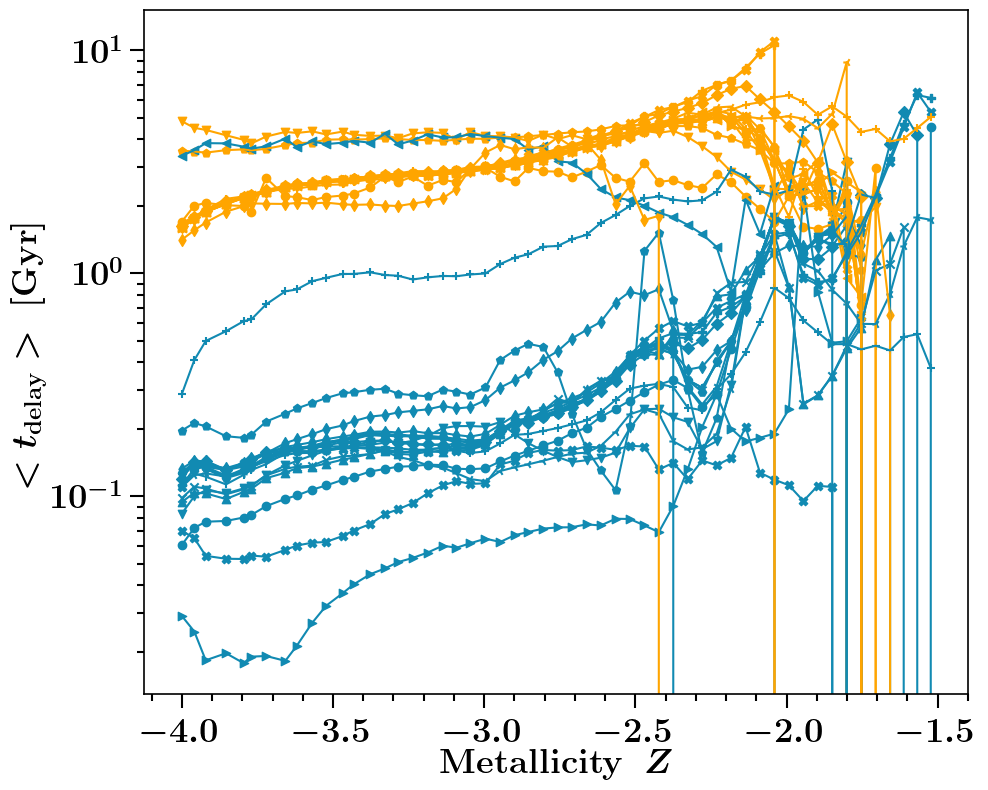

In [13]:
whichQuantity='median'
ncols, nrows= 1,1
f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BBH']: #'BNS', 'BHNS', 
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)





        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False, add_model_label=False) 



        
        
##  SAVE FIG  ###
plt.tight_layout()
plt.subplots_adjust(wspace=0., hspace=0.18)  
plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + 'combi' + '_' + whichQuantity + '.png', transparent=False, dpi=300)
plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + 'combi' + '_' + whichQuantity + '.pdf', transparent=True)
plt.show()
plt.close()

In [ ]:
Change the above to include and go to zero if metallicity doesnt exist. 